In [37]:
import deepmind_lab
import gymnasium as gym
# from gymnasium.envs.registration import register
from gymnasium import spaces
from gymnasium.spaces import Box, Dict, Discrete, MultiDiscrete, Tuple
from ray.rllib.algorithms.impala import ImpalaConfig
import GPUtil
from ray import air
from ray import tune
import ray
import numpy as np
import dm_env
import tensorflow as tf
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.utils.framework import try_import_tf
from tensorflow.keras import layers, Sequential, Model
from deepmind_lab import dmenv_module
from ray.rllib import env
from ray.rllib.algorithms.impala import ImpalaConfig
from ray import air
from ray import tune
from ray.tune.logger import pretty_print
from ray.rllib.algorithms import impala
import cv2
from ray.rllib.models import ModelCatalog
from IPython.display import display
import PIL
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

2023-12-06 05:32:13,258	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


## Custom Model: CNN + ResNet, LSTM

## Forward Pass Custom Model + CPC Loss + REC Loss

In [7]:
from ray.rllib.models.modelv2 import ModelV2
from ray.rllib.models.tf.recurrent_net import RecurrentNetwork
from ray.rllib.policy.rnn_sequencing import add_time_dimension
from ray.rllib.utils.annotations import override
from keras import backend as K
from tensorflow.keras.layers import Layer

tf1, tf, tfv = try_import_tf()

class CNNRNNModel(TFModelV2):

    def __init__(
        self, obs_space, action_space, num_outputs, model_config, name, cnn_shape
    ):

        super(CNNRNNModel, self).__init__(
            obs_space, action_space, num_outputs, model_config, name
        )
        self.current_slot = tf.Variable(0, trainable=False, dtype=tf.int32)
        self.cell_size = 256
        visual_size = cnn_shape[0] * cnn_shape[1] * cnn_shape[2]
        
        self.memory_slots = 1024  # Number of memory slots
        self.embedding_dim = 256  # Assuming embedding dimension
        self.k_nearest_neighbors = 10
        self.memory_keys = tf.Variable(tf.zeros([self.memory_slots, self.embedding_dim]), trainable=False)
        self.memory_values = tf.Variable(tf.zeros([self.memory_slots, self.embedding_dim]), trainable=False)
        self.memory_pixel_inputs = tf.Variable(tf.zeros([self.memory_slots, self.embedding_dim]), trainable=False)
        
        # Initialize weights for key and query transformations
        self.W_k = tf.Variable(tf.random.normal([self.embedding_dim * 2, self.embedding_dim]), name='W_k')
        self.b_k = tf.Variable(tf.zeros([self.embedding_dim]), name='b_k')
        self.W_q = tf.Variable(tf.random.normal([self.embedding_dim * 2, self.embedding_dim]), name='W_q')
        self.b_q = tf.Variable(tf.zeros([self.embedding_dim]), name='b_q')

        state_in_h = tf.keras.layers.Input(shape=(self.cell_size,), name="h")
        state_in_c = tf.keras.layers.Input(shape=(self.cell_size,), name="c")
        seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

        visual_inputs = tf.keras.layers.Input(shape=(None, visual_size), name="visual_inputs")
        
        input_visual = tf.reshape(visual_inputs, [-1, cnn_shape[0], cnn_shape[1], cnn_shape[2]])
        
        # Create and use the model
        self.CNNmodel = CNNModel()
        
        # Assume input_visual is provided
        self.vision_out = self.CNNmodel(input_visual)

        #later used for cp loss
        self.encoded_trajectory = self.vision_out

        self.memory_read_layer = MemoryReadLayer(self.memory_keys, self.memory_values, self.memory_pixel_inputs, self.W_k, self.b_k, self.W_q, self.b_q)

        self.m_t = tf.zeros([1, self.embedding_dim], name = "m_t")

        m_t_tiled = tf.tile(self.m_t, [tf.shape(self.vision_out)[0], 1])
        
        concatenated_output = tf.concat([self.vision_out, m_t_tiled], axis=1)

        concatenated_output = tf.reshape(concatenated_output, [-1, tf.shape(visual_inputs)[1], concatenated_output.shape.as_list()[-1]])

        self.N = 16  # Number of future steps to predict
        
        lstm_out, state_h, state_c = tf.keras.layers.LSTM(
            self.cell_size, return_sequences=True, return_state=True, name="lstm"
        )(
            inputs=concatenated_output,
            mask=tf.sequence_mask(seq_in),
            initial_state=[state_in_h, state_in_c],
        )
       
        self.memory_write_layer = MemoryWriteLayer(self.memory_slots, self.embedding_dim, self.W_k, self.b_k, self.memory_keys, self.memory_values, self.memory_pixel_inputs, self.current_slot)
        
        
        # Postprocess LSTM output with another hidden layer and compute values.
        logits = tf.keras.layers.Dense(
            self.num_outputs, activation=tf.keras.activations.linear, name="logits"
        )(lstm_out)
        values = tf.keras.layers.Dense(1, activation=None, name="values")(lstm_out)

        # Each prediction for a future timestep
        self.latent_z = tf.keras.layers.Dense(units=256, activation="linear")(state_h)

        self.weights = [tf.Variable(
                            initial_value=tf.random.uniform(shape=(self.cell_size, self.cell_size), 
                                                            minval=-0.05, maxval=0.05), 
                            trainable=True, 
                            name=f'W_{i}')
                        for i in range(self.N)]

        # Create the RNN model      
        self.rnn_model = tf.keras.Model(
            inputs=[visual_inputs, seq_in, state_in_h, state_in_c],
            outputs=[logits, values, state_h, state_c],
        )
        self.rnn_model.summary()

    # @tf.function
    @override(ModelV2)
    def forward(self, input_dict, state, seq_lens):
        
        flat_inputs = input_dict["obs_flat"]
        
        inputs_with_time_dim = add_time_dimension(
            padded_inputs=flat_inputs, seq_lens=seq_lens, framework="tf"
        ) 
        
        self.m_t = self.memory_read_layer(self.vision_out, state[0])
            
        output, self._value_out, h, c = self.rnn_model(
            [inputs_with_time_dim, seq_lens] + state
        )
        
        self.memory_write_layer(self.vision_out, h)
        
        return tf.reshape(output, [-1, self.num_outputs]), [h, c]


    @override(RecurrentNetwork)
    def forward_rnn(self, inputs, state, seq_lens):
        # Unpack the inputs (visual, action, reward)

        model_out, self._value_out, h, c = self.rnn_model(
            inputs, seq_lens, state[0], state[1]
        )
        return model_out, [h, c]

    @override(ModelV2)
    def get_initial_state(self):
        return [
            np.zeros(self.cell_size, np.float32),
            np.zeros(self.cell_size, np.float32),
        ]

    @override(ModelV2)
    def value_function(self):
        return tf.reshape(self._value_out, [-1])

    def reset_memory(self):
        """Resets the memory slots to their initial state."""
        self.memory_keys.assign(tf.zeros_like(self.memory_keys))
        self.memory_values.assign(tf.zeros_like(self.memory_values))
        self.memory_pixel_inputs.assign(tf.zeros_like(self.memory_pixel_inputs))
        self.current_slot.assign(0)

    
    # @override(ModelV2)
    def custom_loss(self, policy_loss, loss_inputs):
        """Calculates a custom loss on top of the given policy_loss(es).
        """
        cpc_loss = self.compute_cpc_loss(loss_inputs["state_in_0"], 8, 32)

        # rec_loss = self.compute_loss_components(loss_inputs["reward"], loss_inputs["action"], i_t, h_t, W_r, b_r, W_a, b_a, transpose_residual_model)
        
        return policy_loss  + cpc_loss #+ rec_loss

    def log_bilinear_density_function(self, xt_k, ht, k):
        """Compute the log-bilinear density function score.            
        """
        ht = tf.expand_dims(ht, axis = 0)
        Wk = self.weights[k]
        score = tf.exp(tf.matmul(xt_k, tf.matmul(Wk, ht, transpose_b=True)))
        return score

    def compute_cpc_loss(self, state_h, k, T):
        total_loss = 0
        ht = state_h
        self.encoded_trajectory = tf.concat([self.encoded_trajectory, self.latent_z], axis=0)

        def true_fn():
            total_loss = 0
            for t in range(0, T - 2*k):
                positive_sample = self.encoded_trajectory[t + k]
                negative_samples = [self.encoded_trajectory[i] for i in range(k, T - k) if i != t + k]
        
                positive_score = self.log_bilinear_density_function(tf.reshape(positive_sample, shape=[1, -1]), ht[t], t)
                negative_scores = [self.log_bilinear_density_function(tf.reshape(neg_sample, shape=[1, -1]), ht[t], t) for neg_sample in negative_samples]
        
                all_scores = tf.concat([tf.reshape(positive_score, [-1, 1])] + [tf.reshape(score, [-1, 1]) for score in negative_scores], axis=1)
                all_scores = tf.nn.softmax(all_scores)
        
                target = tf.reshape(tf.one_hot(0, depth=T - 2*k), shape=[1, -1])
                loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=all_scores)
                total_loss += loss
        
            return total_loss / (T - 2*k)

        def false_fn():
            # Return a default value or perform some action when the condition is not met
            return tf.constant(0.0)

        # Use tf.cond to execute true_fn or false_fn based on the condition
        cpc_loss = tf.cond(
            tf.shape(self.encoded_trajectory)[0] >= 16,
            true_fn=true_fn,
            false_fn=false_fn
        )

        return cpc_loss

    def compute_reconstruction_loss(self, L_reward, L_action, L_image, c_image = 30, c_action = 1.5, c_reward = 1):
        L_REC = c_image * L_image + c_action * L_action + c_reward * L_reward
        return L_REC

    def compute_loss_components(self, r_t_minus_1, a_t_minus_1, i_t, h_t, W_r, b_r, W_a, b_a, transpose_residual_model):
        # Reward reconstruction loss
        reconstructed_r = self.reconstruct_reward(r_t_minus_1, W_r, b_r)
        L_reward = tf.reduce_sum(tf.square(r_t_minus_1 - reconstructed_r)) / 2
    
        # Action reconstruction loss
        reconstructed_a = self.reconstruct_action(a_t_minus_1, W_a, b_a)
        L_action = tf.reduce_sum(tf.square(a_t_minus_1 - reconstructed_a)) / 2
    
        # Image reconstruction loss
        reconstructed_i = self.reconstruct_image(h_t, transpose_residual_model)
        L_image = -tf.reduce_sum(i_t * tf.math.log(tf.sigmoid(reconstructed_i)) + 
                                 (1 - i_t) * tf.math.log(1 - tf.sigmoid(reconstructed_i)))
    
        return L_reward, L_action, L_image

    def reconstruct_image(self, h_t, transpose_residual_model):
        return transpose_residual_model(h_t)
        
    def reconstruct_reward(self, r_t_minus_1, W_r, b_r):
        return tf.matmul(r_t_minus_1, W_r) + b_r

    def reconstruct_action(self, a_t_minus_1, W_a, b_a):
        return tf.matmul(a_t_minus_1, W_a) + b_a



class CNNModel(tf.keras.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        input_visual = tf.keras.layers.Input(shape=(84, 84, 1), name="visual_inputs")

        # input_visual = tf.reshape(inputs, [-1, 84, 84, 1])

        # CNN layers
        x = input_visual
        for filters in [16, 32, 32]:
            x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
            x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
            for _ in range(2):  # Two residual blocks
                residual = x
                x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
                x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
                x = tf.keras.layers.Add()([x, residual])
                x = tf.keras.layers.ReLU()(x)

        x = tf.keras.layers.Flatten()(x)
        vision_out = tf.keras.layers.Dense(256, activation='relu')(x)

        self.cnn_model = tf.keras.Model(inputs=[input_visual], outputs=[vision_out])

    def call(self, inputs):
        return self.cnn_model(inputs)

class MemoryReadLayer(Layer):
    def __init__(self, memory_keys, memory_values, memory_pixel_inputs, W_k, b_k, W_q, b_q):
        super(MemoryReadLayer, self).__init__()
        self.memory_keys = memory_keys
        self.memory_values = memory_values
        self.memory_pixel_inputs = memory_pixel_inputs
        self.k_nearest_neighbors = 10
        self.W_q = W_q
        self.b_q = b_q
        self.W_k = W_k
        self.b_k = b_k

    # @tf.function
    # @tf.autograph.experimental.do_not_convert
    def call(self, x_t, h_t_minus_1):
        query = tf.matmul(tf.concat([x_t, h_t_minus_1], axis=1), self.W_q) + self.b_q

        def process_query(single_query):
            distances = tf.norm(self.memory_keys - single_query, axis=1)
            k_nearest_indices = tf.argsort(distances)[:self.k_nearest_neighbors]
            k_nearest_values = tf.gather(self.memory_values, k_nearest_indices)
            k_nearest_pixel_inputs = tf.gather(self.memory_pixel_inputs, k_nearest_indices)

            k_nearest_recomputed_keys = tf.matmul(tf.concat([k_nearest_pixel_inputs, k_nearest_values], axis=1), self.W_k) + self.b_k
            k_nearest_distances = tf.norm(k_nearest_recomputed_keys - single_query, axis=1)

            weights = 1 / (1 + tf.square(k_nearest_distances))
            weights /= tf.reduce_sum(weights, 0)
            m_t = tf.reduce_sum(weights[:, None] * k_nearest_values, axis=0)

            return m_t

        m_t_combined = tf.map_fn(process_query, query, dtype=tf.float32)
        return m_t_combined

class MemoryWriteLayer(tf.keras.layers.Layer):
    def __init__(self, memory_slots, embedding_dim, W_k, b_k, memory_keys, memory_values, memory_pixel_inputs, current_slot):
        super(MemoryWriteLayer, self).__init__()
        self.memory_slots = memory_slots
        self.embedding_dim = embedding_dim
        self.W_k = W_k
        self.b_k = b_k
        self.memory_keys = memory_keys
        self.memory_values = memory_values
        self.memory_pixel_inputs = memory_pixel_inputs
        self.current_slot = current_slot
        
    # @tf.function
    # @tf.autograph.experimental.do_not_convert
    def call(self, x_t, h_t):
        def update_memory(i):
            next_slot = (self.current_slot + 1) % self.memory_slots
            key = tf.matmul(tf.concat([x_t[i:i+1], h_t[i:i+1]], axis=1), self.W_k) + self.b_k
    
            self.memory_keys[next_slot].assign(key[0])
            self.memory_values[next_slot].assign(h_t[i])
            self.memory_pixel_inputs[next_slot].assign(x_t[i])
            self.current_slot.assign(next_slot)
            return i

        tf.map_fn(update_memory, tf.range(tf.shape(x_t)[0]), dtype=tf.int32)
        return x_t  # Return value is not used, but necessary for layer call


## Environment Wrapper of PsychLab environments for Ray RLlib

In [20]:
class DeepMindLabEnv(gym.Env):
    def __init__(self, env_config=None):
        env_config = env_config or {}

        #print(env_config)
        level_script = env_config.get('level_script', 'contributed/psychlab/memory_suite_01/arbitrary_visuomotor_mapping_train')
        #print(level_script)
        config = env_config.get('config', {})
        #print(config)
        self._env = deepmind_lab.Lab(level_script, ['RGB_INTERLEAVED'], config)
        #print(self._env)
        self._action = np.zeros([7], dtype=np.intc)
       # print(self._action)
        self._num_episodes = env_config.get('num_episodes', 1)
        #print(self._num_episodes)
        self.spec = gym.envs.registration.EnvSpec(
            id='DeepMindLab-v0',
            max_episode_steps=12000,  # Set your desired max episode steps here
        )
        observation_spec = self._env.observation_spec()[0]
        #print(observation_spec)
        self.observation_space = gym.spaces.Box(
            low=0, high=1, 
            shape=[84, 84, 1], # observation_spec['shape'], 
            dtype=np.float32 # np.uint8
        )
        #print("7")

        action_spec = self._env.action_spec()
        
        #self.action_space = gym.spaces.Box(low=low, high=high, dtype=np.intc)
        self.action_space =  gym.spaces.Dict({
            'look_left_right':  gym.spaces.Box(low=-512, high=512, shape=(1,), dtype=np.intc),
            # 'look_down_up':  gym.spaces.Box(low=-512, high=512, shape=(1,), dtype=np.intc),
        })
        # print(self._env.action_spec())
        self.steps = 0
        self._current_episode = 0
        self._reward = 0

    def step(self, action):
        # print(action)
        extracted_values = [value[0] for value in action.values()]
        self._action[0] = extracted_values[0]
        # self._action[1] = extracted_values[1]
        # print(self._action)
        reward = self._env.step(self._action, num_steps=1)

        self.steps += 1
        done = not self._env.is_running()

        if not done:
            obs = self._preprocess_obs(self._env.observations()['RGB_INTERLEAVED'])
            
        if done:
            self._current_episode += 1
            obs, _ = self.reset()

        return obs, reward, done, False, {}

    def reset(self, *, seed=None, options=None):
        self._env.reset()
        self._current_episode = 0
        return self._preprocess_obs(self._env.observations()['RGB_INTERLEAVED']), {}
        
    def _preprocess_obs(self, obs):
        
        gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        normalized_obs = gray_obs.astype(np.float32) / 255.0
        resized_obs = cv2.resize(normalized_obs, (84, 84))
        processed_obs = np.expand_dims(resized_obs, axis=-1)
        
        return processed_obs

# Training Agent

## For testing on holdout set comment 'num_learner_workers' attribute

In [12]:
ray.shutdown()
ray.init(num_gpus = 0)

cnn_shape = (84, 84, 1)

# Register our custom model.
ModelCatalog.register_custom_model("my_model", CNNRNNModel)

config = (
    ImpalaConfig()
    .environment(
        env=DeepMindLabEnv,
        env_config={
            "level_script": "contributed/psychlab/memory_suite_01/continuous_recognition_train",
            "config": {
                'fps': str(30),
                'width': str(84),
                'height': str(84)
            },
            "num_episodes": 1000
        }
    )
    .training(
        _separate_vf_optimizer=True,
        _lr_vf=0.00075,
        num_sgd_iter=6,
        vf_loss_coeff=0.01,
        vtrace=True,
        train_batch_size=16,
        model={
            "vf_share_layers": False,
            "custom_model": "my_model",
            "custom_model_config": {
                "cnn_shape": cnn_shape,
            },
            "max_seq_len": 20,
        },
    )
    .rollouts(
        num_envs_per_worker=5,
        num_rollout_workers=8,
        observation_filter="MeanStdFilter",
    )
    .resources(
        num_gpus=0,
        num_cpus_per_worker=1,
    )
    .framework(framework="tf2")
)



algo = config.build()
for i in range(1001):
    result = algo.train()
    #print(result)
    if i % 10 == 0:
        print(i, result)
        checkpoint_dir = algo.save().checkpoint.path
        print(f"Checkpoint saved in directory {checkpoint_dir}")


2023-12-03 17:47:53,536	INFO worker.py:1642 -- Started a local Ray instance.
/home/vaibhav/.local/lib/python3.8/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/vaibhav/.local/lib/python3.8/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/vaibhav/.local/lib/python3.8/site-packages/ray/tune/logger/unified.py:53: R

(RolloutWorker pid=17847) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17847) {
(RolloutWorker pid=17847)   ['cameraLook'] = {
(RolloutWorker pid=17847)     ['1'] = 2
(RolloutWorker pid=17847)     ['2'] = 90
(RolloutWorker pid=17847)     ['3'] = 0
(RolloutWorker pid=17847)   }
(RolloutWorker pid=17847)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17847)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17847)   ['camera'] = {
(RolloutWorker pid=17847)     ['1'] = 0
(RolloutWorker pid=17847)     ['2'] = -30
(RolloutWorker pid=17847)     ['3'] = 150
(RolloutWorker pid=17847)   }
(RolloutWorker pid=17847)   ['gadgetSelect'] = false
(RolloutWorker pid=17847)   ['screenSize'] = {
(RolloutWorker pid=17847)     ['height'] = 512
(RolloutWorker pid=17847)     ['width'] = 512
(RolloutWorker pid=17847)   }
(RolloutWorker pid=17847)   ['environment'] = {
(RolloutWorker pid=17847)     ['finishTrial'] = func

(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <bound method CNNModel.call of <__main__.CNNModel object at 0x7efa10091e80>> and will run it as-is.
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f8632a30>
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(RolloutWorker pid=17846) 2023-12-03 17:48:03,619	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_modelv2.TFModelV2` has been deprecated. Use `ray.rllib.core.rl_module.RLModule` instead. This will raise an error in the future!


(RolloutWorker pid=17849) Model: "model_1"
(RolloutWorker pid=17849) __________________________________________________________________________________________________
(RolloutWorker pid=17849)  Layer (type)                Output Shape                 Param #   Connected to                  
(RolloutWorker pid=17849) ==================================================================================================
(RolloutWorker pid=17849)  visual_inputs (InputLayer)  [(None, None, 7056)]         0         []                            
(RolloutWorker pid=17849)  tf.reshape (TFOpLambda)     (None, 84, 84, 1)            0         ['visual_inputs[0][0]']       
(RolloutWorker pid=17849)  cnn_model (CNNModel)        (None, 256)                  1088800   ['tf.reshape[0][0]']          
(RolloutWorker pid=17849)  tf.compat.v1.shape (TFOpLa  (2,)                         0         ['cnn_model[0][0]']           
(RolloutWorker pid=17849)  mbda)                                                  

(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <bound method MemoryReadLayer.call of <__main__.MemoryReadLayer object at 0x7ef9f8622640>> and will run it as-is.
(RolloutWorker pid=17849) WARNING:tensorflow:From /home/vaibhav/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:648: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
(RolloutWorker pid=17849) Instructions for updating:
(RolloutWorker pid=17849) Use fn_output_signature instead
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8243700> and will run it as-is.
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <bound method MemoryWriteLayer.call of <__main__.MemoryWriteLayer object at 0x7ef9f85e16d0>> and will run it as-is.
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <

(RolloutWorker pid=17849) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 24x across cluster]
(RolloutWorker pid=17849) { [repeated 24x across cluster]
(RolloutWorker pid=17849)   ['cameraLook'] = { [repeated 24x across cluster]
(RolloutWorker pid=17849)     ['3'] = 150 [repeated 144x across cluster]
(RolloutWorker pid=17849) } [repeated 120x across cluster]
(RolloutWorker pid=17849)   ['episodeLengthSeconds'] = 300 [repeated 24x across cluster]
(RolloutWorker pid=17849)   ['timeoutIfIdle'] = false [repeated 24x across cluster]
(RolloutWorker pid=17849)   ['camera'] = { [repeated 24x across cluster]
(RolloutWorker pid=17849)   ['gadgetSelect'] = false [repeated 24x across cluster]
(RolloutWorker pid=17849)   ['screenSize'] = { [repeated 24x across cluster]
(RolloutWorker pid=17849)     ['height'] = 512 [repeated 24x across cluster]
(RolloutWorker pid=17849)     ['width'] = 512 [repeated 24x across cluster]
(Ro

(RolloutWorker pid=17849) Using deprecated observation format: 'RGB_INTERLACED' [repeated 8x across cluster]
(RolloutWorker pid=17849) Using deprecated observation format: 'RGBD_INTERLACED' [repeated 8x across cluster]
(RolloutWorker pid=17846) 2023-12-03 17:48:05,745	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_action_dist.MultiActionDistribution` has been deprecated. Use `ray.rllib.models.tf.tf_distributions.TfMultiDistribution` instead. This will raise an error in the future!
(RolloutWorker pid=17846) 2023-12-03 17:48:05,747	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_action_dist.MultiCategorical` has been deprecated. Use `ray.rllib.models.tf.tf_distributions.TfMultiCategorical` instead. This will raise an error in the future!
(RolloutWorker pid=17846) 2023-12-03 17:48:05,747	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_action_dist.Categorical` has been deprecated. Use `ray.rllib.models.tf.tf_distri

(RolloutWorker pid=17851) Model: "model_1" [repeated 7x across cluster]
(RolloutWorker pid=17851) __________________________________________________________________________________________________ [repeated 14x across cluster]
(RolloutWorker pid=17851)  Layer (type)                Output Shape                 Param #   Connected to                   [repeated 7x across cluster]
(RolloutWorker pid=17851) ================================================================================================== [repeated 14x across cluster]
(RolloutWorker pid=17851)  visual_inputs (InputLayer)  [(None, None, 7056)]         0         []                             [repeated 7x across cluster]
(RolloutWorker pid=17851)  tf.reshape (TFOpLambda)     (None, 84, 84, 1)            0         ['visual_inputs[0][0]']        [repeated 7x across cluster]
(RolloutWorker pid=17851)  cnn_model (CNNModel)        (None, 256)                  1088800   ['tf.reshape[0][0]']           [repeated 7x across cluster]
(R

(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <bound method MemoryReadLayer.call of <__main__.MemoryReadLayer object at 0x7fc468172cd0>> and will run it as-is. [repeated 7x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:From /home/vaibhav/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:648: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version. [repeated 7x across cluster]
(RolloutWorker pid=17851) Instructions for updating: [repeated 7x across cluster]
(RolloutWorker pid=17851) Use fn_output_signature instead [repeated 7x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc45856aee0> and will run it as-is. [repeated 23x across cluster]


(RolloutWorker pid=17849) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 37x across cluster]
(RolloutWorker pid=17849) { [repeated 37x across cluster]
(RolloutWorker pid=17849)   ['cameraLook'] = { [repeated 37x across cluster]
(RolloutWorker pid=17849)     ['3'] = 150 [repeated 222x across cluster]
(RolloutWorker pid=17849) } [repeated 185x across cluster]
(RolloutWorker pid=17849)   ['episodeLengthSeconds'] = 300 [repeated 37x across cluster]
(RolloutWorker pid=17849)   ['timeoutIfIdle'] = false [repeated 37x across cluster]
(RolloutWorker pid=17849)   ['camera'] = { [repeated 37x across cluster]
(RolloutWorker pid=17849)   ['gadgetSelect'] = false [repeated 37x across cluster]
(RolloutWorker pid=17849)   ['screenSize'] = { [repeated 37x across cluster]
(RolloutWorker pid=17849)     ['height'] = 512 [repeated 37x across cluster]
(RolloutWorker pid=17849)     ['width'] = 512 [repeated 37x across cluster]
(Ro

(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <bound method MemoryWriteLayer.call of <__main__.MemoryWriteLayer object at 0x7fc468153790>> and will run it as-is. [repeated 7x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc45856ab80> and will run it as-is. [repeated 22x across cluster]
(RolloutWorker pid=17847) Using deprecated observation format: 'RGB_INTERLACED' [repeated 16x across cluster]
(RolloutWorker pid=17847) Using deprecated observation format: 'RGBD_INTERLACED' [repeated 16x across cluster]


(RolloutWorker pid=17850) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 48x across cluster]
(RolloutWorker pid=17850) { [repeated 48x across cluster]
(RolloutWorker pid=17850)   ['cameraLook'] = { [repeated 48x across cluster]
(RolloutWorker pid=17850)     ['3'] = 150 [repeated 288x across cluster]
(RolloutWorker pid=17850) } [repeated 240x across cluster]
(RolloutWorker pid=17850)   ['episodeLengthSeconds'] = 300 [repeated 48x across cluster]
(RolloutWorker pid=17850)   ['timeoutIfIdle'] = false [repeated 48x across cluster]
(RolloutWorker pid=17850)   ['camera'] = { [repeated 48x across cluster]
(RolloutWorker pid=17850)   ['gadgetSelect'] = false [repeated 48x across cluster]
(RolloutWorker pid=17850)   ['screenSize'] = { [repeated 48x across cluster]
(RolloutWorker pid=17850)     ['height'] = 512 [repeated 48x across cluster]
(RolloutWorker pid=17850)     ['width'] = 512 [repeated 48x across cluster]
(Ro

2023-12-03 17:48:20,291	INFO trainable.py:188 -- Trainable.setup took 25.487 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


(RolloutWorker pid=17849) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 19x across cluster]
(RolloutWorker pid=17849) { [repeated 19x across cluster]
(RolloutWorker pid=17849)   ['cameraLook'] = { [repeated 19x across cluster]
(RolloutWorker pid=17849)     ['3'] = 150 [repeated 114x across cluster]
(RolloutWorker pid=17849) } [repeated 95x across cluster]
(RolloutWorker pid=17849)   ['episodeLengthSeconds'] = 300 [repeated 19x across cluster]
(RolloutWorker pid=17849)   ['timeoutIfIdle'] = false [repeated 19x across cluster]
(RolloutWorker pid=17849)   ['camera'] = { [repeated 19x across cluster]
(RolloutWorker pid=17849)   ['gadgetSelect'] = false [repeated 19x across cluster]
(RolloutWorker pid=17849)   ['screenSize'] = { [repeated 19x across cluster]
(RolloutWorker pid=17849)     ['height'] = 512 [repeated 19x across cluster]
(RolloutWorker pid=17849)     ['width'] = 512 [repeated 19x across cluster]
(Rol

(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) Using deprecated observation format: 'RGB_INTERLACED' [repeated 15x across cluster]
(RolloutWorker pid=17851) Using deprecated observation format: 'RGBD_INTERLACED' [repeated 15x across cluster]


(RolloutWorker pid=17846) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 31x across cluster]
(RolloutWorker pid=17846) { [repeated 31x across cluster]
(RolloutWorker pid=17846)   ['cameraLook'] = { [repeated 31x across cluster]
(RolloutWorker pid=17846)     ['3'] = 150 [repeated 186x across cluster]
(RolloutWorker pid=17846) } [repeated 155x across cluster]
(RolloutWorker pid=17846)   ['episodeLengthSeconds'] = 300 [repeated 31x across cluster]
(RolloutWorker pid=17846)   ['timeoutIfIdle'] = false [repeated 31x across cluster]
(RolloutWorker pid=17846)   ['camera'] = { [repeated 31x across cluster]
(RolloutWorker pid=17846)   ['gadgetSelect'] = false [repeated 31x across cluster]
(RolloutWorker pid=17846)   ['screenSize'] = { [repeated 31x across cluster]
(RolloutWorker pid=17846)     ['height'] = 512 [repeated 31x across cluster]
(RolloutWorker pid=17846)     ['width'] = 512 [repeated 31x across cluster]
(Ro

(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae8269670> and will run it as-is.
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ae079b670>
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ae8269e50> and will run it as-is.


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 27x across cluster]


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile [repeated 5x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36884aaf70> and will run it as-is. [repeated 69x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 137x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f8425580> [repeated 137x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 137x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36884aaf70> and will run it as-is. [repeated 69x across cluste

(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


/home/vaibhav/.local/lib/python3.8/site-packages/ray/rllib/utils/metrics/window_stat.py:50: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(self.items[: self.count]))
/home/vaibhav/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {}, 'num_env_steps_sampled': 2000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 2000, 'num_agent_steps_trained': 0, 'num_training_step_calls_since_last_synch_worker_weights': 206, 'num_samples_added_to_queue': 2000, 'num_weight_broadcasts': 8, 'learner_queue': {'size_count': 0, 'size_mean': nan, 'size_std': nan, 'size_quantiles': array(40., dtype=float32)}, 'timing_breakdown': {'learner_grad_time_ms': 0.0, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'learner_dequeue_time_ms': 8083.958}}, 'sampler_results': {'episode_reward_max': nan, 'episode_reward_min': nan, 'episode_reward_mean': nan, 'episode_len_mean': nan, 'episode_media': {}, 'episodes_this_iter': 0, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [], 'episode_lengths': []}, 'sampler_perf': {}, 'num_faulty_episodes': 0, 'connector_metrics': {}}, 'episode

(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec4861bb80> and will run it as-is. [repeated 51x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 103x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec24184160> [repeated 103x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 103x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458658160> and will run it as-is. [repeated 50x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae0625b80> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab01afa00> [repeated 80x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458618b80> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec241c3790> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec24184b80> [repeated 80x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458658430> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WAR

(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 2x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a0216d30> and will run it as-is. [repeated 9x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 15x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a01fe0d0> [repeated 15x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 15x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f921429ddc0> and will run it as-is. [repeated 6x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 23x across cluster]


(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36885e11f0> and will run it as-is. [repeated 32x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 66x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f36606675e0> [repeated 66x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 66x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec4861b820> and will run it as-is. [repeated 34x across cluster]
(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]


(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92142d9ee0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f9214282c10> [repeated 79x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92143d6040> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WAR

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a846493a0> and will run it as-is. [repeated 24x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 52x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7a847b2ca0> [repeated 52x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 52x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec241c3c10> and will run it as-is. [repeated 28x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 21x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0943619d0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0941639d0> [repeated 79x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d0502ee0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) WAR

(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 10x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d03d99d0> and will run it as-is.
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 6x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc094243c10> [repeated 6x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 6x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d03d9550> and will run it as-is. [repeated 5x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could no

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 21x across cluster]


(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8325790> and will run it as-is. [repeated 6x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 8x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f852c430> [repeated 8x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 8x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8325dc0> and will run it as-is. [repeated 2x across cluster]


10 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 0.0010330795, 'entropy': 6.5668063, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.6782, 'vf_loss': 0.0061480417, 'vf_explained_var': 0.00025935596}, 'grad_gnorm': [13.077621, 16.681963], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 408.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 22250, 'num_env_steps_trained': 108000, 'num_agent_steps_sampled': 22250, 'num_agent_steps_trained': 108000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 22250, 'num_weight_broadcasts': 18, 'learner_queue': {'size_count': 432, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1644.299, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'l

(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec487d0310> and will run it as-is. [repeated 34x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 72x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec240bdd60> [repeated 72x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 72x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec487b9ee0> and will run it as-is. [repeated 38x across cluster]
(RolloutWorker pid=17849) lib

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8243ca0> and will run it as-is. [repeated 21x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 35x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a033c850> [repeated 35x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 35x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18469790> and will run it as-is. [repeated 14x across cluster]
(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile [repeated 4x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]


(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f921429dd30> and will run it as-is. [repeated 19x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 45x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f92241a0940> [repeated 45x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 45x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f921429dd30> and will run it as-is. [repeated 26x across cluster]
(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) lib

(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005ea60> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef974710b20> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8325280> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) lib

(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae048cca0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 76x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7a84578760> [repeated 76x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 76x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4586450d0> and will run it as-is. [repeated 37x across cluster]
(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) lib

(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 3x across cluster]


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec240275e0> and will run it as-is.
(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 32x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec24358250> [repeated 32x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 32x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec48614d30> and will run it as-is. [repeated 14x across cluster]


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 9x across cluster]
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc458618c10> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 48x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3e44bc8e0> [repeated 48x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 48x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc3e43c31f0> and will run it as-is. [repeated 26x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f921410c820> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f9214432a30> [repeated 80x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f921410c8b0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36884aab80> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f36606bf580> [repeated 80x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36884aa9d0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile [repeated 3x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92141dc670> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f9214385e50> [repeated 80x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92141dc310> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f83bc5e0> and will run it as-is. [repeated 22x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 47x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9d47ad130> [repeated 47x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 47x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18503af0> and will run it as-is. [repeated 25x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]
20 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 0.0136476355, 'entropy': 6.473684, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.6809, 'vf_loss': 0.003957985, 'vf_explained_var': -0.000680397}, 'grad_gnorm': [10.586059, 13.10464], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 888.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 42250, 'num_env_steps_trained': 228000, 'num_agent_steps_sampled': 42250, 'num_agent_steps_trained': 228000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 42250, 'num_weight_broadcasts': 28, 'learner_queue': {'size_count': 912, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 't

(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc09419b5e0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e9825ba60> [repeated 79x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18327a60> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) lib

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]


(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f921429dee0> and will run it as-is. [repeated 5x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 15x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc094243340> [repeated 15x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 15x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0943c33a0> and will run it as-is. [repeated 10x across cluster]
(RolloutWorker pid=17850) libp

(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 24x across cluster]


(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f366056af70> and will run it as-is. [repeated 16x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 27x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f36885b0df0> [repeated 27x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 27x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc3e4643f70> and will run it as-is. [repeated 11x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4e98427040> and will run it as-is. [repeated 24x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 53x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e98475940> [repeated 53x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 53x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4eac2cc160> and will run it as-is. [repeated 29x across cluster]
(RolloutWorker pid=17849) WAR

(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 23x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae05dcca0> and will run it as-is. [repeated 3x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 9x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab01af520> [repeated 9x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 9x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ae05dcf70> and will run it as-is. [repeated 6x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8347550> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f8511af0> [repeated 81x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458658820> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 11x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ab01be670> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab01ac880> [repeated 80x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36604c51f0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec48614c10> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec2418c250> [repeated 80x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec14604d30> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8325160> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f82ef400> [repeated 79x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f83259d0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) lib

(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 20x across cluster]


(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f3660237310> and will run it as-is. [repeated 16x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 35x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f36606bf8e0> [repeated 35x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 35x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458618a60> and will run it as-is. [repeated 19x across cluster]


30 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 0.02050353, 'entropy': 6.422325, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.6893, 'vf_loss': 0.007130603, 'vf_explained_var': 0.0015893616}, 'grad_gnorm': [13.262502, 29.336914], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 1368.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 62250, 'num_env_steps_trained': 348000, 'num_agent_steps_sampled': 62250, 'num_agent_steps_trained': 348000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 62250, 'num_weight_broadcasts': 38, 'learner_queue': {'size_count': 1392, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1592.983, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'lear

(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae05dc790> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab0177e50> [repeated 79x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7a84279310> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) WAR

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 2x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92502f0a60> and will run it as-is. [repeated 33x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 70x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f91f4791550> [repeated 70x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 70x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92502f0f70> and will run it as-is. [repeated 37x across cluster]
(RolloutWorker pid=17847) WAR

(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc3e43c3550> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 11x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc458765d30> [repeated 11x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 11x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc3e43c3b80> and will run it as-is. [repeated 9x across cluster]
(RolloutWorker pid=17853) libpn

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d05789d0> and will run it as-is. [repeated 16x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 38x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0d03d74c0> [repeated 38x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 38x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0c84aa0d0> and will run it as-is. [repeated 22x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8347c10> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9d4250eb0> [repeated 81x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f91f46780d0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92503001f0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f9214180610> [repeated 79x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f925009b790> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec14604430> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0d03fcd00> [repeated 80x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d043b940> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) lib

(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 21x across cluster]
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 2x across cluster]


(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc3e4134040> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc42c04c670> [repeated 81x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc3e40ee3a0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36607e18b0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f36886b47f0> [repeated 80x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc04c7d7280> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]
(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc45842ac10> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc46806e460> [repeated 79x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4586875e0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) WAR

(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]
40 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.0035677126, 'entropy': 6.4584618, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.68915, 'vf_loss': 0.0018753093, 'vf_explained_var': 0.01088854}, 'grad_gnorm': [6.997208, 19.580988], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 1848.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 82250, 'num_env_steps_trained': 468000, 'num_agent_steps_sampled': 82250, 'num_agent_steps_trained': 468000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 82250, 'num_weight_broadcasts': 48, 'learner_queue': {'size_count': 1872, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}

(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f18686e50> and will run it as-is. [repeated 24x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 51x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0d0424370> [repeated 51x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 51x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc09419b040> and will run it as-is. [repeated 27x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec487b9a60> and will run it as-is. [repeated 36x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 66x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec14512790> [repeated 66x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 66x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc45842ac10> and w

(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 11x across cluster]


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d043b160> and will run it as-is. [repeated 4x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 14x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc094163220> [repeated 14x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 14x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0c84aa0d0> and will run it as-is. [repeated 10x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 9x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f3688369ee0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4eac18e670> [repeated 80x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f441ba280> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) lib

(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 20x across cluster]
(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile [repeated 3x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec4861b4c0> and will run it as-is. [repeated 18x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 42x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec147022b0> [repeated 42x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 42x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec4861bdc0> and will run it as-is. [repeated 24x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f83259d0> and will run it as-is. [repeated 11x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 26x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f8435d00> [repeated 26x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 26x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9a005ec10> and will run it as-is. [repeated 15x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]


(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36105dc9d0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f361057e280> [repeated 80x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92503001f0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 20x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc45855a700> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc458688a90> [repeated 80x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc04c43cd30> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 10x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005eca0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a0309d90> [repeated 79x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9a005e430> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) WAR

(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f921410c700> and will run it as-is. [repeated 3x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 11x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc46806e3a0> [repeated 11x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 11x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc3e43c3160> and will run it as-is. [repeated 8x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005e160> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a02e3cd0> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef974334310> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) lib

50 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.0055934265, 'entropy': 6.3537326, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.6912, 'vf_loss': 0.0024212897, 'vf_explained_var': 0.016549962}, 'grad_gnorm': [7.3193154, 13.857984], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 2328.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 102250, 'num_env_steps_trained': 588000, 'num_agent_steps_sampled': 102250, 'num_agent_steps_trained': 588000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 102250, 'num_weight_broadcasts': 58, 'learner_queue': {'size_count': 2352, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1615.988, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0

(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8325160> and will run it as-is. [repeated 17x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 41x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f843d520> [repeated 41x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 41x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8325430> and will run it as-is. [repeated 24x across cluster]
(RolloutWorker pid=17846) WAR

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 21x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae05dcca0> and will run it as-is. [repeated 4x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 12x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7a745da6d0> [repeated 12x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 12x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ab01be790> and will run it as-is. [repeated 8x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7efa10073b80> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f8327c40> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4e98427b80> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WAR

(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 11x across cluster]


(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8347b80> and will run it as-is. [repeated 16x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 26x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef97433bfa0> [repeated 26x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 26x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7a84586940> and will run it as-is. [repeated 10x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 20x across cluster]


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec487b9a60> and will run it as-is. [repeated 25x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 55x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec147024f0> [repeated 55x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 55x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36884aaf70> and will run it as-is. [repeated 30x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 21x across cluster]


(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f185d6940> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e982a38b0> [repeated 80x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc3e43c3c10> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 26x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7efa32ef5040> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9742d8730> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f922472b160> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8347e50> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f83275b0> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f921410c040> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8325940> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a01528b0> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4840414c0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]
(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc04c1a7a60> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0d04242e0> [repeated 80x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4e8c2b6d30> and will run it as-is. [repeated 40x across cluster]


60 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.019573117, 'entropy': 6.2076874, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.691, 'vf_loss': 0.0036972489, 'vf_explained_var': 0.0057725073}, 'grad_gnorm': [10.493789, 17.909132], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 2808.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 122250, 'num_env_steps_trained': 708000, 'num_agent_steps_sampled': 122250, 'num_agent_steps_trained': 708000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 122250, 'num_weight_broadcasts': 68, 'learner_queue': {'size_count': 2832, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1659.459, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0,

(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae03ec310> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab01af7c0> [repeated 80x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f922472b3a0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc4584d0ca0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f921422a5e0> [repeated 79x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f9250300160> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) WAR

(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae051a700> and will run it as-is.
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 2x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ae0741f70> [repeated 2x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 2x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f9250310310> and will run it as-is.
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36884aa8b0> and will run it as-is

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 20x across cluster]


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0d05049a0> [repeated 79x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc09419b1f0> and will run it as-is. [repeated 38x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc09419b430> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0d06fc220> [repeated 80x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0943c34c0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d043b700> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f361019ba30> [repeated 81x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36604c50d0> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc45842a9d0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]


(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e9829bbe0> [repeated 80x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4e8c116d30> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc42c059c10> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec241ae700> [repeated 79x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec041eb4c0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec041eb040> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) lib

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 44x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc458771ca0> [repeated 44x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 44x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc45842a040> and will run it as-is. [repeated 20x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4e8c2b6ee0> and will run it as-is. [repeated 24x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 11x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a029baf0> [repeated 79x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8360700> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f83605e0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Ple

70 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.013288186, 'entropy': 6.52351, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.978, 'vf_loss': 0.0021520103, 'vf_explained_var': -0.00044928864}, 'grad_gnorm': [6.598348, 17.384632], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 3288.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 142250, 'num_env_steps_trained': 828000, 'num_agent_steps_sampled': 142250, 'num_agent_steps_trained': 828000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 142250, 'num_weight_broadcasts': 78, 'learner_queue': {'size_count': 3312, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1644.55, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, '

(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 10x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e98331fd0> [repeated 10x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 10x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae03ec310> and will run it as-is. [repeated 4x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f185d6790> and will run it as-is. [repeated 6x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 9x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9742d84c0> [repeated 9x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 9x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a037f5e0> and will run it as-is. [repeated 7x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36ac058b80> and will run it as-is. [repeated 2x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 2x across cluster]


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 71x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f92502376d0> [repeated 71x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 71x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f921410c160> and will run it as-is. [repeated 33x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f922472b310> and will run it as-is. [repeated 38x across cluster]
(RolloutWorker pid=17849) Ple

(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 15x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc09402b850> [repeated 15x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 15x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0c84aa430> and will run it as-is. [repeated 7x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36604c54c0> and will run it as-is. [repeated 8x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 11x across cluster]


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e9829b880> [repeated 79x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4eac2ccf70> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4eac2ccf70> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Ple

(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f9224192eb0>
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f918c06c040> and will run it as-is.
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005e670> and will run it as-is.
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f921410c700> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f92503795b0> [repeated 79x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f922472b160> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92500abb80> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f83a28e0> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f82438b0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) WAR

(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 20x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36885e11f0> and will run it as-is.
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f3660515bb0>
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36885e1e50> and will run it as-is.
(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a037f160> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f857f100> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f921410cca0> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec1443d790> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec486f5490> [repeated 80x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc03c6d0e50> and will run it as-is. [repeated 40x across cluster]


80 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 0.013234089, 'entropy': 6.4233932, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.9829, 'vf_loss': 0.0043199793, 'vf_explained_var': -0.0010238563}, 'grad_gnorm': [9.022961, 22.558146], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 3768.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 162250, 'num_env_steps_trained': 948000, 'num_agent_steps_sampled': 162250, 'num_agent_steps_trained': 948000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 162250, 'num_weight_broadcasts': 88, 'learner_queue': {'size_count': 3792, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1627.35, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 

(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae0625670> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab02ebfa0> [repeated 79x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ae03ec3a0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec4842b040> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc09439e7f0> [repeated 80x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d0502ee0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc458687430> and will run it as-is. [repeated 19x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 43x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc458688dc0> [repeated 43x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 43x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc45842a9d0> and will run it as-is. [repeated 24x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4e7c79b8b0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e7c531940> [repeated 80x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4e98427310> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17848) lib

(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f3688703f70> and will run it as-is. [repeated 20x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 44x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f3610181d30> [repeated 44x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 44x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f3688703310> and will run it as-is. [repeated 24x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a00d2f70> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a005f910> [repeated 81x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec4842b670> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005ed30> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f8520850> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f3688412ca0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a84586670> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab02b16a0> [repeated 80x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36ac0583a0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc45856af70> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc4587711f0> [repeated 79x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458618430> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7febb86c4670> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec4874b580> [repeated 80x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec48614b80> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) lib

90 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.056500584, 'entropy': 6.424433, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.9837, 'vf_loss': 0.003172636, 'vf_explained_var': -0.008578539}, 'grad_gnorm': [8.608108, 25.565561], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 4248.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 182250, 'num_env_steps_trained': 1068000, 'num_agent_steps_sampled': 182250, 'num_agent_steps_trained': 1068000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 182250, 'num_weight_broadcasts': 98, 'learner_queue': {'size_count': 4272, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1644.813, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0,

(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc42c059670> and will run it as-is. [repeated 15x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 37x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3e43b5910> [repeated 37x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 37x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458618430> and will run it as-is. [repeated 22x across cluster]
(RolloutWorker pid=17847) lib

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0943c3c10> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc04c4ac8e0> [repeated 81x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92502f0c10> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17851) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17851) {
(RolloutWorker pid=17851)   ['cameraLook'] = {
(RolloutWorker pid=17851)     ['1'] = 2
(RolloutWorker pid=17851)     ['2'] = 90
(RolloutWorker pid=17851)     ['3'] = 0
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17851)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17851)   ['camera'] = {
(RolloutWorker pid=17851)     ['1'] = 0
(RolloutWorker pid=17851)     ['2'] = -30
(RolloutWorker pid=17851)     ['3'] = 150
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['gadgetSelect'] = false
(RolloutWorker pid=17851)   ['screenSize'

(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae052ad30> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab02ebfd0> [repeated 79x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ae052adc0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17851) {
(RolloutWorker pid=17851)   ['cameraLook'] = {
(RolloutWorker pid=17851)     ['1'] = 2
(RolloutWorker pid=17851)     ['2'] = 90
(RolloutWorker pid=17851)     ['3'] = 0
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17851)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17851)   ['camera'] = {
(RolloutWorker pid=17851)     ['1'] = 0
(RolloutWorker pid=17851)     ['2'] = -30
(RolloutWorker pid=17851)     ['3'] = 150
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['gadgetSelect'] = false
(RolloutWorker pid=17851)   ['screenSize'] = {
(RolloutWorker pid=17851)     ['height'] = 512
(RolloutWorker pid=17851)     ['width'] = 512
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['environment'] = {
(RolloutWorker pid=17851)     ['finishTrial'] = func

(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f185038b0> and will run it as-is. [repeated 33x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 63x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9686ff8e0> [repeated 63x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 63x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8325b80> and will run it as-is. [repeated 30x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc458618310> and will run it as-is. [repeated 7x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 17x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3cc6a3430> [repeated 17x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 17x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc42c059670> and will run it as-is. [repeated 10x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7febb85efb80> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec486f59d0> [repeated 81x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d0502700> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f18503700> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4f187387c0> [repeated 80x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18424dc0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 10x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7febb84f1a60> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec143a6e50> [repeated 80x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc45842a9d0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc458618160> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc39c55e520> [repeated 79x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458618dc0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17848) WAR

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a604aa5e0> and will run it as-is. [repeated 24x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 56x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7a604a0580> [repeated 56x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 56x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7a607953a0> and will run it as-is. [repeated 32x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17848) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17848) {
(RolloutWorker pid=17848)   ['cameraLook'] = {
(RolloutWorker pid=17848)     ['1'] = 2
(RolloutWorker pid=17848)     ['2'] = 90
(RolloutWorker pid=17848)     ['3'] = 0
(RolloutWorker pid=17848)   }
(RolloutWorker pid=17848)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17848)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17848)   ['camera'] = {
(RolloutWorker pid=17848)     ['1'] = 0
(RolloutWorker pid=17848)     ['2'] = -30
(RolloutWorker pid=17848)     ['3'] = 150
(RolloutWorker pid=17848)   }
(RolloutWorker pid=17848)   ['gadgetSelect'] = false
(RolloutWorker pid=17848)   ['screenSize'] = {
(RolloutWorker pid=17848

(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc42c059820> and will run it as-is. [repeated 36x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 71x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4f185e7940> [repeated 71x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 71x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18327550> and will run it as-is. [repeated 35x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ab01be4c0> and will run it as-is. [repeated 3x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 7x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab01acf10> [repeated 7x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 7x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7a604c0d30> and will run it as-is. [repeated 4x across cluster]
(RolloutWorker pid=17847) libpng w

100 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.049082935, 'entropy': 6.405992, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.9844, 'vf_loss': 0.0052224915, 'vf_explained_var': 0.05307128}, 'grad_gnorm': [10.728194, 27.546204], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 4728.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 202250, 'num_env_steps_trained': 1188000, 'num_agent_steps_sampled': 202250, 'num_agent_steps_trained': 1188000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 202250, 'num_weight_broadcasts': 108, 'learner_queue': {'size_count': 4752, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1583.648, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.

(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 2x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc39c43c7c0> [repeated 2x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 2x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4586581f0> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec48614dc0> and will run it as-is.
(RolloutWorker pid=17849) Please report this to the TensorFlow 

(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36885e1940> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 20x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f36886c0b50> [repeated 20x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 20x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36885e1e50> and will run it as-is. [repeated 12x across cluster]
(RolloutWorker pid=17849) WAR

(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 22x across cluster]
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a60795b80> and will run it as-is. [repeated 25x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 55x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7a60640df0> [repeated 55x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 55x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ae048cca0> and will run it as-is. [repeated 30x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17851) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17851) {
(RolloutWorker pid=17851)   ['cameraLook'] = {
(RolloutWorker pid=17851)     ['1'] = 2
(RolloutWorker pid=17851)     ['2'] = 90
(RolloutWorker pid=17851)     ['3'] = 0
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17851)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17851)   ['camera'] = {
(RolloutWorker pid=17851)     ['1'] = 0
(RolloutWorker pid=17851)     ['2'] = -30
(RolloutWorker pid=17851)     ['3'] = 150
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['gadgetSelect'] = false
(RolloutWorker pid=17851)   ['screenSize'] = {
(RolloutWorker pid=17851)     ['height'] = 512
(RolloutWorker pid=17851)     ['width'] = 512
(RolloutWorker pid=1785

(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a037f5e0> and will run it as-is. [repeated 34x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 66x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef96810fbb0> [repeated 66x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 66x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d05029d0> and will run it as-is. [repeated 32x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials [repeated 2x across cluster]
(RolloutWorker pid=17849) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 5x across cluster]
(RolloutWorker pid=17849) { [repeated 5x across cluster]
(RolloutWorker pid=17849)   ['cameraLook'] = { [repeated 5x across cluster]
(RolloutWorker pid=17849)     ['3'] = 150 [repeated 30x across cluster]
(RolloutWorker pid=17849) } [repeated 25x across cluster]
(RolloutWorker pid=17849)   ['episodeLengthSeconds'] = 300 [repeated 5x across cluster]
(RolloutWorker pid=17849)   ['timeoutIfIdle'] = false [repeated 5x across cluster]
(RolloutWorker pid=17849)   ['camera'] = { [repeated 5x across cluster]
(RolloutWorker pid=17849)   ['gadgetSelect'] = false [repeated 5x across cluster]
(RolloutWorker pid=17849)   ['screenSize'] = { [repeated 5x across cluster]
(RolloutWorker pid=17849)     

(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc4586581f0> and will run it as-is. [repeated 5x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 12x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc46807af70> [repeated 12x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 12x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4586580d0> and will run it as-is. [repeated 7x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials [repeated 2x across cluster]
(RolloutWorker pid=17846) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 4x across cluster]
(RolloutWorker pid=17846) { [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['cameraLook'] = { [repeated 4x across cluster]
(RolloutWorker pid=17846)     ['3'] = 150 [repeated 24x across cluster]
(RolloutWorker pid=17846) } [repeated 20x across cluster]
(RolloutWorker pid=17846)   ['episodeLengthSeconds'] = 300 [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['timeoutIfIdle'] = false [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['camera'] = { [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['gadgetSelect'] = false [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['screenSize'] = { [repeated 4x across cluster]
(RolloutWorker pid=17846)     

(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec4861ba60> and will run it as-is. [repeated 17x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 30x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec24155cd0> [repeated 30x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 30x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc3e43c30d0> and will run it as-is. [repeated 13x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]
(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4eac2cc160> and will run it as-is. [repeated 23x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 50x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e7c3f71c0> [repeated 50x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 50x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18424dc0> and will run it as-is. [repeated 27x across cluster]
(RolloutWorker pid=17853) lib

(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17851) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17851) {
(RolloutWorker pid=17851)   ['cameraLook'] = {
(RolloutWorker pid=17851)     ['1'] = 2
(RolloutWorker pid=17851)     ['2'] = 90
(RolloutWorker pid=17851)     ['3'] = 0
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17851)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17851)   ['camera'] = {
(RolloutWorker pid=17851)     ['1'] = 0
(RolloutWorker pid=17851)     ['2'] = -30
(RolloutWorker pid=17851)     ['3'] = 150
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['gadgetSelect'] = false
(RolloutWorker pid=17851)   ['screenSize'

(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a845869d0> and will run it as-is. [repeated 14x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 32x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ae061a790> [repeated 32x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 32x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ae05dce50> and will run it as-is. [repeated 18x across cluster]
(RolloutWorker pid=17848) lib

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 22x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17849) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 3x across cluster]
(RolloutWorker pid=17849) { [repeated 3x across cluster]
(RolloutWorker pid=17849)   ['cameraLook'] = { [repeated 3x across cluster]
(RolloutWorker pid=17849)     ['3'] = 150 [repeated 18x across cluster]
(RolloutWorker pid=17849) } [repeated 15x across cluster]
(RolloutWorker pid=17849)   ['episodeLengthSeconds'] = 300 [repeated 3x across cluster]
(RolloutWorker pid=17849)   ['timeoutIfIdle'] = false [repeated 3x across cluster]
(RolloutWorker pid=17849)   ['camera'] = { [repeated 3x across cluster]
(RolloutWorker pid=17849)   ['gadgetSelect'] = false [repeated 3x across cluster]
(RolloutWorke

(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8513550> and will run it as-is. [repeated 7x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 17x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a00ab190> [repeated 17x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 17x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f85134c0> and will run it as-is. [repeated 10x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005e1f0> and will run it as-is. [repeated 14x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 25x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f82f09d0> [repeated 25x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 25x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0c84aa430> and will run it as-is. [repeated 11x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 9x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc39c51e9d0> and will run it as-is. [repeated 26x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 55x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3e4600310> [repeated 55x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 55x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc39c51edc0> and will run it as-is. [repeated 29x across cluster]
(RolloutWorker pid=17849) lib

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f921429d160> and will run it as-is. [repeated 3x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 9x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f925034d7c0> [repeated 9x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 9x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92503003a0> and will run it as-is. [repeated 6x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile [repeated 3x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005e790> and will run it as-is. [repeated 15x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 26x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f35f0750e80> [repeated 26x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 26x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36885e1940> and will run it as-is. [repeated 11x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 2x across cluster]


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f185d6940> and will run it as-is. [repeated 25x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 54x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e8c122940> [repeated 54x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 54x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f185d6dc0> and will run it as-is. [repeated 29x across cluster]


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17853) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17853) {
(RolloutWorker pid=17853)   ['cameraLook'] = {
(RolloutWorker pid=17853)     ['1'] = 2
(RolloutWorker pid=17853)     ['2'] = 90
(RolloutWorker pid=17853)     ['3'] = 0
(RolloutWorker pid=17853)   }
(RolloutWorker pid=17853)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17853)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17853)   ['camera'] = {
(RolloutWorker pid=17853)     ['1'] = 0
(RolloutWorker pid=17853)     ['2'] = -30
(RolloutWorker pid=17853)     ['3'] = 150
(RolloutWorker pid=17853)   }
(RolloutWorker pid=17853)   ['gadgetSelect'] = false
(RolloutWorker pid=17853)   ['screenSize'] = {
(RolloutWorker pid=17853)     ['height'] = 512
(RolloutWorker pid=17853)     ['width'] = 512
(RolloutWorker pid=1785

(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f18503e50> and will run it as-is. [repeated 12x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 22x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e984a08b0> [repeated 22x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 22x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18503e50> and will run it as-is. [repeated 10x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]
110 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.014769523, 'entropy': 6.461527, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.98553, 'vf_loss': 0.003000034, 'vf_explained_var': 0.32169667}, 'grad_gnorm': [6.5876923, 17.898817], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 5208.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 222250, 'num_env_steps_trained': 1308000, 'num_agent_steps_sampled': 222250, 'num_agent_steps_trained': 1308000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 222250, 'num_weight_broadcasts': 118, 'learner_queue': {'size_count': 5232, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 1

(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36604c5790> and will run it as-is. [repeated 29x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 59x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f36605a9ca0> [repeated 59x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 59x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f921429d040> and will run it as-is. [repeated 30x across cluster]
(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17848) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 2x across cluster]
(RolloutWorker pid=17848) { [repeated 2x across cluster]
(RolloutWorker pid=17848)   ['cameraLook'] = { [repeated 2x across cluster]
(RolloutWorker pid=17848)     ['3'] = 150 [repeated 12x across cluster]
(RolloutWorker pid=17848) } [repeated 10x across cluster]
(RolloutWorker pid=17848)   ['episodeLengthSeconds'] = 300 [repeated 2x across cluster]
(RolloutWorker pid=17848)   ['timeoutIfIdle'] = false [repeated 2x across cluster]
(RolloutWorker pid=17848)   ['camera'] = { [repeated 2x across cluster]
(RolloutWorker pid=17848)   ['gadgetSelect'] = false [repeated 2x across cluster]
(RolloutWorke

(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f185d6a60> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e7c57cb20> [repeated 79x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f185d60d0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) WAR

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec4861b550> and will run it as-is. [repeated 6x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 16x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec1456f730> [repeated 16x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 16x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7febb83be4c0> and will run it as-is. [repeated 10x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 9x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 2x across cluster]


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005e040> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f366039d1c0> [repeated 80x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f35f027ea60> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17851) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17851) {
(RolloutWorker pid=17851)   ['cameraLook'] = {
(RolloutWorker pid=17851)     ['1'] = 2
(RolloutWorker pid=17851)     ['2'] = 90
(RolloutWorker pid=17851)     ['3'] = 0
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17851)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17851)   ['camera'] = {
(RolloutWorker pid=17851)     ['1'] = 0
(RolloutWorker pid=17851)     ['2'] = -30
(RolloutWorker pid=17851)     ['3'] = 150
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['gadgetSelect'] = false
(RolloutWorker pid=17851)   ['screenSize'] = {
(RolloutWorker pid=17851)     ['height'] = 512
(RolloutWorker pid=17851)     ['width'] = 512
(RolloutWorker pid=1785

(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17851) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17851) {
(RolloutWorker pid=17851)   ['cameraLook'] = {
(RolloutWorker pid=17851)     ['1'] = 2
(RolloutWorker pid=17851)     ['2'] = 90
(RolloutWorker pid=17851)     ['3'] = 0
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17851)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17851)   ['camera'] = {
(RolloutWorker pid=17851)     ['1'] = 0
(RolloutWorker pid=17851)     ['2'] = -30
(RolloutWorker pid=17851)     ['3'] = 150
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['gadgetSelect'] = false
(RolloutWorker pid=17851)   ['screenSize'] = {
(RolloutWorker pid=17851)     ['height'] = 512
(RolloutWorker pid=17851)     ['width'] = 512
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['environment'] = {
(RolloutWorker pid=17851)     ['finishTrial'] = func

(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc458658310> and will run it as-is. [repeated 38x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 76x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc39c2944c0> [repeated 76x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 76x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458658a60> and will run it as-is. [repeated 38x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17850) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 2x across cluster]
(RolloutWorker pid=17850) { [repeated 2x across cluster]
(RolloutWorker pid=17850)   ['cameraLook'] = { [repeated 2x across cluster]
(RolloutWorker pid=17850)     ['3'] = 150 [repeated 12x across cluster]
(RolloutWorker pid=17850) } [repeated 10x across cluster]
(RolloutWorker pid=17850)   ['episodeLengthSeconds'] = 300 [repeated 2x across cluster]
(RolloutWorker pid=17850)   ['timeoutIfIdle'] = false [repeated 2x across cluster]
(RolloutWorker pid=17850)   ['camera'] = { [repeated 2x across cluster]
(RolloutWorker pid=17850)   ['gadgetSelect'] = false [repeated 2x across cluster]
(RolloutWorker pid=17850)   ['screenSize'] = { [repeated 2x across cluster]
(RolloutWorker pid=17850)     ['height'] = 512 [repeated 2x

(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9d47a9d30> and will run it as-is. [repeated 3x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 5x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9681c1940> [repeated 5x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 5x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc42c0591f0> and will run it as-is. [repeated 2x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17847) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 4x across cluster]
(RolloutWorker pid=17847) { [repeated 4x across cluster]
(RolloutWorker pid=17847)   ['cameraLook'] = { [repeated 4x across cluster]
(RolloutWorker pid=17847)     ['3'] = 150 [repeated 24x across cluster]
(RolloutWorker pid=17847) } [repeated 20x across cluster]
(RolloutWorker pid=17847)   ['episodeLengthSeconds'] = 300 [repeated 4x across cluster]
(RolloutWorker pid=17847)   ['timeoutIfIdle'] = false [repeated 4x across cluster]
(RolloutWorker pid=17847)   ['camera'] = { [repeated 4x across cluster]
(RolloutWorker pid=17847)   ['gadgetSelect'] = false [repeated 4x across cluster]
(RolloutWorker pid=17847)   ['screenSize'] = { [repeated 4x across cluster]
(RolloutWorker pid=17847)     ['height'] = 512 [repeated 4x

(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec48523e50> and will run it as-is. [repeated 37x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 74x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7febb83f88b0> [repeated 74x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 74x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec485238b0> and will run it as-is. [repeated 37x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 3x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec48523d30> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 5x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec48673d00> [repeated 5x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 5x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7febb84f1c10> and will run it as-is. [repeated 3x across cluster]
(RolloutWorker pid=17846) libpng w

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 22x across cluster]
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17856) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17856) {
(RolloutWorker pid=17856)   ['cameraLook'] = {
(RolloutWorker pid=17856)     ['1'] = 2
(RolloutWorker pid=17856)     ['2'] = 90
(RolloutWorker pid=17856)     ['3'] = 0
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17856)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17856)   ['camera'] = {
(RolloutWorker pid=17856)     ['1'] = 0
(RolloutWorker pid=17856)     ['2'] = -30
(RolloutWorker pid=17856)     ['3'] = 150
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['gadgetSelect'] = false
(RolloutWorker pid=17856)   ['screenSize'

(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d043b8b0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0940b1b50> [repeated 80x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0943c3160> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17856) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17856) {
(RolloutWorker pid=17856)   ['cameraLook'] = {
(RolloutWorker pid=17856)     ['1'] = 2
(RolloutWorker pid=17856)     ['2'] = 90
(RolloutWorker pid=17856)     ['3'] = 0
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17856)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17856)   ['camera'] = {
(RolloutWorker pid=17856)     ['1'] = 0
(RolloutWorker pid=17856)     ['2'] = -30
(RolloutWorker pid=17856)     ['3'] = 150
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['gadgetSelect'] = false
(RolloutWorker pid=17856)   ['screenSize'] = {
(RolloutWorker pid=17856)     ['height'] = 512
(RolloutWorker pid=17856)     ['width'] = 512
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['environment'] = {
(RolloutWorker pid=17856)     ['finishTrial'] = func

(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f18503670> and will run it as-is. [repeated 28x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 52x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4f1866c250> [repeated 52x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 52x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4584d09d0> and will run it as-is. [repeated 24x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17849) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 2x across cluster]
(RolloutWorker pid=17849) { [repeated 2x across cluster]
(RolloutWorker pid=17849)   ['cameraLook'] = { [repeated 2x across cluster]
(RolloutWorker pid=17849)     ['3'] = 150 [repeated 12x across cluster]
(RolloutWorker pid=17849) } [repeated 10x across cluster]
(RolloutWorker pid=17849)   ['episodeLengthSeconds'] = 300 [repeated 2x across cluster]
(RolloutWorker pid=17849)   ['timeoutIfIdle'] = false [repeated 2x across cluster]
(RolloutWorker pid=17849)   ['camera'] = { [repeated 2x across cluster]
(RolloutWorker pid=17849)   ['gadgetSelect'] = false [repeated 2x across cluster]
(RolloutWorker pid=17849)   ['screenSize'] = { [repeated 2x across cluster]
(RolloutWorker pid=17849)     ['height'] = 512 [repeated 2x

(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4e7c243a60> and will run it as-is. [repeated 12x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 27x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e7c347df0> [repeated 27x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 27x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d0578e50> and will run it as-is. [repeated 15x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17851) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17851) {
(RolloutWorker pid=17851)   ['cameraLook'] = {
(RolloutWorker pid=17851)     ['1'] = 2
(RolloutWorker pid=17851)     ['2'] = 90
(RolloutWorker pid=17851)     ['3'] = 0
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17851)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17851)   ['camera'] = {
(RolloutWorker pid=17851)     ['1'] = 0
(RolloutWorker pid=17851)     ['2'] = -30
(RolloutWorker pid=17851)     ['3'] = 150
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['gadgetSelect'] = false
(RolloutWorker pid=17851)   ['screenSize'

(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec485231f0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec145dc700> [repeated 80x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec487b9dc0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17851) {
(RolloutWorker pid=17851)   ['cameraLook'] = {
(RolloutWorker pid=17851)     ['1'] = 2
(RolloutWorker pid=17851)     ['2'] = 90
(RolloutWorker pid=17851)     ['3'] = 0
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17851)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17851)   ['camera'] = {
(RolloutWorker pid=17851)     ['1'] = 0
(RolloutWorker pid=17851)     ['2'] = -30
(RolloutWorker pid=17851)     ['3'] = 150
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['gadgetSelect'] = false
(RolloutWorker pid=17851)   ['screenSize'] = {
(RolloutWorker pid=17851)     ['height'] = 512
(RolloutWorker pid=17851)     ['width'] = 512
(RolloutWorker pid=17851)   }
(RolloutWorker pid=17851)   ['environment'] = {
(RolloutWorker pid=17851)     ['finishTrial'] = func

(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4e7c243d30> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e7c2d5b50> [repeated 80x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc484041e50> and will run it as-is. [repeated 40x across cluster]


120 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.0332655, 'entropy': 6.469715, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.98737, 'vf_loss': 0.0023022706, 'vf_explained_var': 0.121890806}, 'grad_gnorm': [6.436729, 26.11666], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 5688.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 242250, 'num_env_steps_trained': 1428000, 'num_agent_steps_sampled': 242250, 'num_agent_steps_trained': 1428000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 242250, 'num_weight_broadcasts': 128, 'learner_queue': {'size_count': 5712, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1676.366, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0,

(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9681c8160> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a0256130> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec48523280> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17850) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17850) {
(RolloutWorker pid=17850)   ['cameraLook'] = {
(RolloutWorker pid=17850)     ['1'] = 2
(RolloutWorker pid=17850)     ['2'] = 90
(RolloutWorker pid=17850)     ['3'] = 0
(RolloutWorker pid=17850)   }
(RolloutWorker pid=17850)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17850)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17850)   ['camera'] = {
(RolloutWorker pid=17850)     ['1'] = 0
(RolloutWorker pid=17850)     ['2'] = -30
(RolloutWorker pid=17850)     ['3'] = 150
(RolloutWorker pid=17850)   }
(RolloutWorker pid=17850)   ['gadgetSelect'] = false
(RolloutWorker pid=17850)   ['screenSize'

(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d043baf0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3e448bb80> [repeated 79x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc458658790> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) lib

(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec14604040> and will run it as-is. [repeated 23x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 43x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f82bb250> [repeated 43x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 43x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9a037f040> and will run it as-is. [repeated 20x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials [repeated 3x across cluster]
(RolloutWorker pid=17856) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 7x across cluster]
(RolloutWorker pid=17856) { [repeated 7x across cluster]
(RolloutWorker pid=17856)   ['cameraLook'] = { [repeated 7x across cluster]
(RolloutWorker pid=17856)     ['3'] = 150 [repeated 42x across cluster]
(RolloutWorker pid=17856) } [repeated 35x across cluster]
(RolloutWorker pid=17856)   ['episodeLengthSeconds'] = 300 [repeated 7x across cluster]
(RolloutWorker pid=17856)   ['timeoutIfIdle'] = false [repeated 7x across cluster]
(RolloutWorker pid=17856)   ['camera'] = { [repeated 7x across cluster]
(RolloutWorker pid=17856)   ['gadgetSelect'] = false [repeated 7x across cluster]
(RolloutWorker pid=17856)   ['screenSize'] = { [repeated 7x across cluster]
(RolloutWorker pid=17856)     

(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d043bdc0> and will run it as-is. [repeated 18x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 38x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0d0512cd0> [repeated 38x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 38x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36885e1e50> and will run it as-is. [repeated 20x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials [repeated 2x across cluster]
(RolloutWorker pid=17846) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 4x across cluster]
(RolloutWorker pid=17846) { [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['cameraLook'] = { [repeated 4x across cluster]
(RolloutWorker pid=17846)     ['3'] = 150 [repeated 24x across cluster]
(RolloutWorker pid=17846) } [repeated 20x across cluster]
(RolloutWorker pid=17846)   ['episodeLengthSeconds'] = 300 [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['timeoutIfIdle'] = false [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['camera'] = { [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['gadgetSelect'] = false [repeated 4x across cluster]
(RolloutWorker pid=17846)   ['screenSize'] = { [repeated 4x across cluster]
(RolloutWorker pid=17846)     

(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f916c644670> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f91f430b8e0> [repeated 79x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f916c6441f0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17853) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17853) {
(RolloutWorker pid=17853)   ['cameraLook'] = {
(RolloutWorker pid=17853)     ['1'] = 2
(RolloutWorker pid=17853)     ['2'] = 90
(RolloutWorker pid=17853)     ['3'] = 0
(RolloutWorker pid=17853)   }
(RolloutWorker pid=17853)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17853)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17853)   ['camera'] = {
(RolloutWorker pid=17853)     ['1'] = 0
(RolloutWorker pid=17853)     ['2'] = -30
(RolloutWorker pid=17853)     ['3'] = 150
(RolloutWorker pid=17853)   }
(RolloutWorker pid=17853)   ['gadgetSelect'] = false
(RolloutWorker pid=17853)   ['screenSize'] = {
(RolloutWorker pid=17853)     ['height'] = 512
(RolloutWorker pid=17853)     ['width'] = 512
(RolloutWorker pid=1785

(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005eca0> and will run it as-is. [repeated 9x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 15x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef93870afa0> [repeated 15x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 15x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9a005eca0> and will run it as-is. [repeated 6x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17848) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 2x across cluster]
(RolloutWorker pid=17848) { [repeated 2x across cluster]
(RolloutWorker pid=17848)   ['cameraLook'] = { [repeated 2x across cluster]
(RolloutWorker pid=17848)     ['3'] = 150 [repeated 12x across cluster]
(RolloutWorker pid=17848) } [repeated 10x across cluster]
(RolloutWorker pid=17848)   ['episodeLengthSeconds'] = 300 [repeated 2x across cluster]
(RolloutWorker pid=17848)   ['timeoutIfIdle'] = false [repeated 2x across cluster]
(RolloutWorker pid=17848)   ['camera'] = { [repeated 2x across cluster]
(RolloutWorker pid=17848)   ['gadgetSelect'] = false [repeated 2x across cluster]
(RolloutWorke

(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f9250065b80> and will run it as-is. [repeated 31x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 65x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f92241dcc70> [repeated 65x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 65x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f9250065ee0> and will run it as-is. [repeated 34x across cluster]
(RolloutWorker pid=17849) lib

(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17850) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17850) {
(RolloutWorker pid=17850)   ['cameraLook'] = {
(RolloutWorker pid=17850)     ['1'] = 2
(RolloutWorker pid=17850)     ['2'] = 90
(RolloutWorker pid=17850)     ['3'] = 0
(RolloutWorker pid=17850)   }
(RolloutWorker pid=17850)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17850)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17850)   ['camera'] = {
(RolloutWorker pid=17850)     ['1'] = 0
(RolloutWorker pid=17850)     ['2'] = -30
(RolloutWorker pid=17850)     ['3'] = 150
(RolloutWorker pid=17850)   }
(RolloutWorker pid=17850)   ['gadgetSelect'] = false
(RolloutWorker pid=17850)   ['screenSize'

(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef968213310> and will run it as-is.
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 4x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef93872ce50> [repeated 4x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 4x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ae052a9d0> and will run it as-is. [repeated 3x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f18

(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 2x across cluster]


(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f9214180ca0> [repeated 80x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f35e87ec280> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f91f40b90d0> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17846) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17846) {
(RolloutWorker pid=17846)   ['cameraLook'] = {
(RolloutWorker pid=17846)     ['1'] = 2
(RolloutWorker pid=17846)     ['2'] = 90
(RolloutWorker pid=17846)     ['3'] = 0
(RolloutWorker pid=17846)   }
(RolloutWorker pid=17846)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17846)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17846)   ['camera'] = {
(RolloutWorker pid=17846)     ['1'] = 0
(RolloutWorker pid=17846)     ['2'] = -30
(RolloutWorker pid=17846)     ['3'] = 150
(RolloutWorker pid=17846)   }
(RolloutWorker pid=17846)   ['gadgetSelect'] = false
(RolloutWorker pid=17846)   ['screenSize'

(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4eac18ec70> [repeated 79x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4eac2cc550> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4eac2cc160> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17856) lib

(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 22x across cluster]


(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 77x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e8c122640> [repeated 77x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 77x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4eac2ccca0> and will run it as-is. [repeated 38x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f18503ee0> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 3x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e18064c70> [repeated 3x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 3x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4eac2ccee0> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4eac2ccca0> and will run it as-is.


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17856) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17856) {
(RolloutWorker pid=17856)   ['cameraLook'] = {
(RolloutWorker pid=17856)     ['1'] = 2
(RolloutWorker pid=17856)     ['2'] = 90
(RolloutWorker pid=17856)     ['3'] = 0
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17856)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17856)   ['camera'] = {
(RolloutWorker pid=17856)     ['1'] = 0
(RolloutWorker pid=17856)     ['2'] = -30
(RolloutWorker pid=17856)     ['3'] = 150
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['gadgetSelect'] = false
(RolloutWorker pid=17856)   ['screenSize'] = {
(RolloutWorker pid=17856)     ['height'] = 512
(RolloutWorker pid=17856)     ['width'] = 512
(RolloutWorker pid=1785

(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae05dcca0> and will run it as-is.


(RolloutWorker pid=17856) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17856) {
(RolloutWorker pid=17856)   ['cameraLook'] = {
(RolloutWorker pid=17856)     ['1'] = 2
(RolloutWorker pid=17856)     ['2'] = 90
(RolloutWorker pid=17856)     ['3'] = 0
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17856)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17856)   ['camera'] = {
(RolloutWorker pid=17856)     ['1'] = 0
(RolloutWorker pid=17856)     ['2'] = -30
(RolloutWorker pid=17856)     ['3'] = 150
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['gadgetSelect'] = false
(RolloutWorker pid=17856)   ['screenSize'] = {
(RolloutWorker pid=17856)     ['height'] = 512
(RolloutWorker pid=17856)     ['width'] = 512
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['environment'] = {
(RolloutWorker pid=17856)     ['finishTrial'] = func

(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 28x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9386aaee0> [repeated 28x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 28x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9a037f0d0> and will run it as-is. [repeated 13x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17856) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17856) {
(RolloutWorker pid=17856)   ['cameraLook'] = {
(RolloutWorker pid=17856)     ['1'] = 2
(RolloutWorker pid=17856)     ['2'] = 90
(RolloutWorker pid=17856)     ['3'] = 0
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17856)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17856)   ['camera'] = {
(RolloutWorker pid=17856)     ['1'] = 0
(RolloutWorker pid=17856)     ['2'] = -30
(RolloutWorker pid=17856)     ['3'] = 150
(RolloutWorker pid=17856)   }
(RolloutWorker pid=17856)   ['gadgetSelect'] = false
(RolloutWorker pid=17856)   ['screenSize'] = {
(RolloutWorker pid=17856)     ['height'] = 512
(RolloutWorker pid=17856)     ['width'] = 512
(RolloutWorker pid=1785

(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc09419b8b0> and will run it as-is. [repeated 36x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 51x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc04c4ac2b0> [repeated 51x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 51x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0c84aaaf0> and will run it as-is. [repeated 26x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 3x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a005e550> and will run it as-is. [repeated 4x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 2x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a01feb80> [repeated 2x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 2x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc09419b790> and will run it as-is.
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef96

130 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.059640735, 'entropy': 6.4632745, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.9883, 'vf_loss': 0.0035943445, 'vf_explained_var': 0.0011141574}, 'grad_gnorm': [8.716824, 21.62525], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 6168.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 262250, 'num_env_steps_trained': 1548000, 'num_agent_steps_sampled': 262250, 'num_agent_steps_trained': 1548000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 262250, 'num_weight_broadcasts': 138, 'learner_queue': {'size_count': 6192, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1653.084, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0

(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f3688369e50> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f36885c8910> [repeated 79x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36607e1790> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17847) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17847) {
(RolloutWorker pid=17847)   ['cameraLook'] = {
(RolloutWorker pid=17847)     ['1'] = 2
(RolloutWorker pid=17847)     ['2'] = 90
(RolloutWorker pid=17847)     ['3'] = 0
(RolloutWorker pid=17847)   }
(RolloutWorker pid=17847)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17847)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17847)   ['camera'] = {
(RolloutWorker pid=17847)     ['1'] = 0
(RolloutWorker pid=17847)     ['2'] = -30
(RolloutWorker pid=17847)     ['3'] = 150
(RolloutWorker pid=17847)   }
(RolloutWorker pid=17847)   ['gadgetSelect'] = false
(RolloutWorker pid=17847)   ['screenSize'] = {
(RolloutWorker pid=17847)     ['height'] = 512
(RolloutWorker pid=17847)     ['width'] = 512
(RolloutWorker pid=1784

(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc4586583a0> and will run it as-is. [repeated 14x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 23x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef96850f070> [repeated 23x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 23x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8243790> and will run it as-is. [repeated 9x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec48523b80> and will run it as-is. [repeated 26x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 57x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec486f5250> [repeated 57x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 57x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec48523a60> and will run it as-is. [repeated 31x across cluster]
(RolloutWorker pid=17856) lib

(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17853) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17853) {
(RolloutWorker pid=17853)   ['cameraLook'] = {
(RolloutWorker pid=17853)     ['1'] = 2
(RolloutWorker pid=17853)     ['2'] = 90
(RolloutWorker pid=17853)     ['3'] = 0
(RolloutWorker pid=17853)   }
(RolloutWorker pid=17853)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17853)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17853)   ['camera'] = {
(RolloutWorker pid=17853)     ['1'] = 0
(RolloutWorker pid=17853)     ['2'] = -30
(RolloutWorker pid=17853)     ['3'] = 150
(RolloutWorker pid=17853)   }
(RolloutWorker pid=17853)   ['gadgetSelect'] = false
(RolloutWorker pid=17853)   ['screenSize'] = {
(RolloutWorker pid=17853

(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17853) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17853) {
(RolloutWorker pid=17853)   ['cameraLook'] = {
(RolloutWorker pid=17853)     ['1'] = 2
(RolloutWorker pid=17853)     ['2'] = 90
(RolloutWorker pid=17853)     ['3'] = 0
(RolloutWorker pid=17853)   }
(RolloutWorker pid=17853)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17853)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17853)   ['camera'] = {
(RolloutWorker pid=17853)     ['1'] = 0
(RolloutWorker pid=17853)     ['2'] = -30
(RolloutWorker pid=17853)     ['3'] = 150
(RolloutWorker pid=17853)   }
(RolloutWorker pid=17853)   ['gadgetSelect'] = false
(RolloutWorker pid=17853)   ['screenSize'] = {
(RolloutWorker pid=17853)     ['height'] = 512
(RolloutWorker pid=17853)     ['width'] = 512
(RolloutWorker pid=17853)   }
(RolloutWorker pid=17853)   ['environment'] = {
(RolloutWorker pid=17853)     ['finishTrial'] = func

(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a60795d30> and will run it as-is. [repeated 16x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 28x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f857f7f0> [repeated 28x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 28x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8325790> and will run it as-is. [repeated 12x across cluster]


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 3x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92141dc5e0> and will run it as-is. [repeated 24x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 52x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f91f47beaf0> [repeated 52x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 52x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92141dcee0> and will run it as-is. [repeated 28x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17848) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17848) {
(RolloutWorker pid=17848)   ['cameraLook'] = {
(RolloutWorker pid=17848)     ['1'] = 2
(RolloutWorker pid=17848)     ['2'] = 90
(RolloutWorker pid=17848)     ['3'] = 0
(RolloutWorker pid=17848)   }
(RolloutWorker pid=17848)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17848)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17848)   ['camera'] = {
(RolloutWorker pid=17848)     ['1'] = 0
(RolloutWorker pid=17848)     ['2'] = -30
(RolloutWorker pid=17848)     ['3'] = 150
(RolloutWorker pid=17848)   }
(RolloutWorker pid=17848)   ['gadgetSelect'] = false
(RolloutWorker pid=17848)   ['screenSize'] = {
(RolloutWorker pid=17848)     ['height'] = 512
(RolloutWorker pid=17848)     ['width'] = 512
(RolloutWorker pid=1784

(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc458618e50> and will run it as-is. [repeated 32x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 61x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a0240370> [repeated 61x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 61x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8243a60> and will run it as-is. [repeated 29x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17850) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17850) {
(RolloutWorker pid=17850)   ['cameraLook'] = {
(RolloutWorker pid=17850)     ['1'] = 2
(RolloutWorker pid=17850)     ['2'] = 90
(RolloutWorker pid=17850)     ['3'] = 0
(RolloutWorker pid=17850)   }
(RolloutWorker pid=17850)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17850)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17850)   ['camera'] = {
(RolloutWorker pid=17850)     ['1'] = 0
(RolloutWorker pid=17850)     ['2'] = -30
(RolloutWorker pid=17850)     ['3'] = 150
(RolloutWorker pid=17850)   }
(RolloutWorker pid=17850)   ['ga

(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec4861baf0> and will run it as-is. [repeated 9x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 20x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec4874bc40> [repeated 20x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 20x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7a604c0820> and will run it as-is. [repeated 11x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17848) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init: [repeated 3x across cluster]
(RolloutWorker pid=17848) { [repeated 3x across cluster]
(RolloutWorker pid=17848)   ['cameraLook'] = { [repeated 3x across cluster]
(RolloutWorker pid=17848)     ['3'] = 150 [repeated 18x across cluster]
(RolloutWorker pid=17848) } [repeated 15x across cluster]
(RolloutWorker pid=17848)   ['episodeLengthSeconds'] = 300 [repeated 3x across cluster]
(RolloutWorker pid=17848)   ['timeoutIfIdle'] = false [repeated 3x across cluster]
(RolloutWorker pid=17848)   ['camera'] = { [repeated 3x across cluster]
(RolloutWorker pid=17848)   ['gadgetSelect'] = false [repeated 3x across cluster]
(RolloutWorke

(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae03ec0d0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ae0734970> [repeated 79x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ae048c8b0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) WAR

(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 21x across cluster]


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7febb84f1700> and will run it as-is. [repeated 25x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 49x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec14645eb0> [repeated 49x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 49x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f35e8732a60> and will run it as-is. [repeated 24x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 21x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d043b5e0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0942546a0> [repeated 79x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d043b3a0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17851) WAR

(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f916c644310> and will run it as-is. [repeated 12x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 27x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f92141be910> [repeated 27x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 27x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f916c644670> and will run it as-is. [repeated 15x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17850) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17850) {
(RolloutWorker pid=17850)   ['cameraLook'] = {
(RolloutWorker pid=17850)     ['1'] = 2
(RolloutWorker pid=17850)     ['2'] = 90
(RolloutWorker pid=17850)     ['3'] = 0
(RolloutWorker pid=17850)   }
(RolloutWorker pid=17850)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17850)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17850)   ['camera'] = {
(RolloutWorker pid=17850)     ['1'] = 0
(RolloutWorker pid=17850)     ['2'] = -30
(RolloutWorker pid=17850)     ['3'] = 150
(RolloutWorker pid=17850)   }
(RolloutWorker pid=17850)   ['gadgetSelect'] = false
(RolloutWorker pid=17850)   ['screenSize'] = {
(RolloutWorker pid=17850)     ['height'] = 512
(RolloutWorker pid=17850)     ['width'] = 512
(RolloutWorker pid=1785

(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92141dcee0> and will run it as-is. [repeated 27x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 51x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef96850fe20> [repeated 51x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 51x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8347b80> and will run it as-is. [repeated 24x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36884aa790> and will run it as-is. [repeated 13x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 29x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f35f0150e80> [repeated 29x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 29x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36ac058af0> and will run it as-is. [repeated 16x across cluster]


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36607e1e50> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f35f0150dc0> [repeated 80x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36885c75e0> and will run it as-is. [repeated 40x across cluster]


140 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 0.068604074, 'entropy': 6.5045295, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.98944, 'vf_loss': 0.0034733915, 'vf_explained_var': 0.009302008}, 'grad_gnorm': [7.353737, 24.597534], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 6648.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 282250, 'num_env_steps_trained': 1668000, 'num_agent_steps_sampled': 282250, 'num_agent_steps_trained': 1668000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 282250, 'num_weight_broadcasts': 148, 'learner_queue': {'size_count': 6672, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1638.62, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.

(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f185d6430> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7febb83b0100> [repeated 80x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec14604040> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc42c059280> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f9214432ca0> [repeated 80x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f91f40b90d0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17851) lib

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc09419bdc0> and will run it as-is. [repeated 17x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 38x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0d0659490> [repeated 38x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 38x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92500ab790> and will run it as-is. [repeated 21x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f921429d280> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f91f43801f0> [repeated 79x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f921429d310> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 23x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7ae048cca0> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ab01cf4f0> [repeated 81x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92503008b0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9a037fdc0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef938495f10> [repeated 79x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9d47a9a60> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 23x across cluster]


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36604c51f0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f35e87d0eb0> [repeated 80x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36604c5ee0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f185d6dc0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4eac186b50> [repeated 80x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f185d6dc0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec487d0ee0> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7feba4678fd0> [repeated 81x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc39462c9d0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d05029d0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc02c48e130> [repeated 79x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d043b8b0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) lib

150 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 0.015771681, 'entropy': 6.428843, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.9921, 'vf_loss': 0.0039986786, 'vf_explained_var': 0.008079563}, 'grad_gnorm': [8.479622, 21.213863], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 7128.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 302250, 'num_env_steps_trained': 1788000, 'num_agent_steps_sampled': 302250, 'num_agent_steps_trained': 1788000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 302250, 'num_weight_broadcasts': 158, 'learner_queue': {'size_count': 7152, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1598.078, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0

(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc468061550> and will run it as-is. [repeated 7x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 17x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3e4564370> [repeated 17x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 17x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc45842a3a0> and will run it as-is. [repeated 10x across cluster]
(RolloutWorker pid=17850) libp

(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:161] Episode ended after 50 trials
(RolloutWorker pid=17846) I game_scripts/levels/contributed/psychlab/factories/continuous_recognition_factory.lua:112] opts passed to _init:
(RolloutWorker pid=17846) {
(RolloutWorker pid=17846)   ['cameraLook'] = {
(RolloutWorker pid=17846)     ['1'] = 2
(RolloutWorker pid=17846)     ['2'] = 90
(RolloutWorker pid=17846)     ['3'] = 0
(RolloutWorker pid=17846)   }
(RolloutWorker pid=17846)   ['episodeLengthSeconds'] = 300
(RolloutWorker pid=17846)   ['timeoutIfIdle'] = false
(RolloutWorker pid=17846)   ['camera'] = {
(RolloutWorker pid=17846)     ['1'] = 0
(RolloutWorker pid=17846

(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f368877a550> and will run it as-is. [repeated 5x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 13x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f368868c520> [repeated 13x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 13x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8347a60> and will run it as-is. [repeated 8x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 2x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a84586820> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7a84582400> [repeated 80x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18586790> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f185d65e0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e0001ce80> [repeated 79x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18503d30> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) lib

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36884121f0> and will run it as-is. [repeated 10x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 16x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f35f03c1a30> [repeated 16x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 16x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec4861b1f0> and will run it as-is. [repeated 6x across cluster]
(RolloutWorker pid=17853) libp

(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]


(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f18503f70> and will run it as-is. [repeated 30x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 64x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4dd76fcdc0> [repeated 64x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 64x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18503f70> and will run it as-is. [repeated 34x across cluster]
(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92141dcaf0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f916c0429d0> [repeated 80x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f9250300dc0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]


(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc04c295a60> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f3660422490> [repeated 79x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f3688703280> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc02c4b7ca0>
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d043b670> and will run it as-is.
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec4861b550> and will run it as-is.
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile [repeated 3x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a607953a0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ae07246d0> [repeated 79x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7a607953a0> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9f8243f70> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 3x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9a03ca7f0> [repeated 3x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 3x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36607e1e50> and will run it as-is.
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef96

160 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 0.0007286106, 'entropy': 6.5519524, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.99005, 'vf_loss': 0.0026385607, 'vf_explained_var': -1.1051694e-06}, 'grad_gnorm': [6.851467, 19.74888], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 7608.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 322250, 'num_env_steps_trained': 1908000, 'num_agent_steps_sampled': 322250, 'num_agent_steps_trained': 1908000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 322250, 'num_weight_broadcasts': 168, 'learner_queue': {'size_count': 7632, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1684.521, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms'

(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec48614310> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7febb8067820> [repeated 80x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f35f0443ca0> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 11x across cluster]
(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 2x across cluster]


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9d47a9a60> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef938355370> [repeated 79x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7efa10073b80> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile [repeated 3x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc45842ae50> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3944f4700> [repeated 80x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc45842ae50> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d043bb80> and will run it as-is. [repeated 26x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 57x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc04c03f370> [repeated 57x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 57x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc03c339550> and will run it as-is. [repeated 31x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4e98427c10> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e7c6d91c0> [repeated 80x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18686820> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec14604ee0> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7fec14702be0> [repeated 81x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7ae82698b0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]
(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d02e31f0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc02c57a790> [repeated 79x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0d02e31f0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WAR

(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7febb847a8b0> and will run it as-is. [repeated 19x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 42x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc39429ce80> [repeated 42x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 42x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4586183a0> and will run it as-is. [repeated 23x across cluster]
(RolloutWorker pid=17848) WAR

(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9d47a9c10> and will run it as-is. [repeated 5x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 14x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9f84c14f0> [repeated 14x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 14x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9a037f1f0> and will run it as-is. [repeated 9x across cluster]


(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 22x across cluster]
(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc42c059c10> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3e44a8370> [repeated 79x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc484041670> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17851) WAR

170 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': -0.02407997, 'entropy': 6.4829774, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.99023, 'vf_loss': 0.0028129604, 'vf_explained_var': 1.3262033e-06}, 'grad_gnorm': [6.7597938, 17.892471], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 8088.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 342250, 'num_env_steps_trained': 2028000, 'num_agent_steps_sampled': 342250, 'num_agent_steps_trained': 2028000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 342250, 'num_weight_broadcasts': 178, 'learner_queue': {'size_count': 8112, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1674.789, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms'

(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3e431df70>
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc39c51eaf0> and will run it as-is.
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f36887035e0> and will run it as-is.
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef9d47a9d30> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f92502f4550> [repeated 79x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92502f0c10> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a60795a60> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7a60728880> [repeated 80x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f7a60795d30> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) lib

(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 10x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7ef968213e50> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f368874c9a0> [repeated 80x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f36884aa8b0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 20x across cluster]


(RolloutWorker pid=17848) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7a845861f0> and will run it as-is. [repeated 41x across cluster]
(RolloutWorker pid=17848) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 81x across cluster]
(RolloutWorker pid=17848) Cause: Unknown node type <gast.gast.Import object at 0x7f7ae06bc9d0> [repeated 81x across cluster]
(RolloutWorker pid=17848) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 81x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc39c51e940> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 20x across cluster]


(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec14604d30> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7feba43e5f70> [repeated 79x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec487b9e50> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) WAR

(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0c84aaaf0> and will run it as-is. [repeated 7x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 18x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0d0424af0> [repeated 18x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 18x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc0c84aa160> and will run it as-is. [repeated 11x across cluster]
(RolloutWorker pid=17850) libp

(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 16x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc03c3390d0> and will run it as-is. [repeated 10x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 24x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc02c22b190> [repeated 24x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 24x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc03c339d30> and will run it as-is. [repeated 14x across cluster]
(RolloutWorker pid=17847) lib

(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 13x across cluster]


(RolloutWorker pid=17850) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f35f04438b0> and will run it as-is. [repeated 24x across cluster]
(RolloutWorker pid=17850) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 51x across cluster]
(RolloutWorker pid=17850) Cause: Unknown node type <gast.gast.Import object at 0x7f366077c0d0> [repeated 51x across cluster]
(RolloutWorker pid=17850) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 51x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc39c51e160> and will run it as-is. [repeated 27x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 25x across cluster]


(RolloutWorker pid=17853) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc3e43c3ee0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc39c61b1c0> [repeated 79x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4584d0160> and will run it as-is. [repeated 40x across cluster]


180 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 0.004401889, 'entropy': 6.45327, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.991, 'vf_loss': 0.003503944, 'vf_explained_var': -2.2227566e-07}, 'grad_gnorm': [7.4355774, 21.960182], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 8568.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 362250, 'num_env_steps_trained': 2148000, 'num_agent_steps_sampled': 362250, 'num_agent_steps_trained': 2148000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 362250, 'num_weight_broadcasts': 188, 'learner_queue': {'size_count': 8592, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1598.67, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0

(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f18686af0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e98343730> [repeated 80x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4f18686790> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f922472b4c0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f92141a0820> [repeated 80x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f922472b940> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17846) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc4584d0d30> and will run it as-is.
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc4586f6d00>
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8325d30> and will run it as-is.
(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile


(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 12x across cluster]


(RolloutWorker pid=17856) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d05785e0> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f916716c340> [repeated 79x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92502f0940> and will run it as-is. [repeated 39x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc09419b8b0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17856) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17856) Cause: Unknown node type <gast.gast.Import object at 0x7fc0207dd040> [repeated 80x across cluster]
(RolloutWorker pid=17856) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc09419b040> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]


(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7efa100734c0> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef96850f040> [repeated 80x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9f8243d30> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc09419bb80> and will run it as-is. [repeated 16x across cluster]
(RolloutWorker pid=17849) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 28x across cluster]
(RolloutWorker pid=17849) Cause: Unknown node type <gast.gast.Import object at 0x7ef9d425fa60> [repeated 28x across cluster]
(RolloutWorker pid=17849) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 28x across cluster]
(RolloutWorker pid=17849) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef9681c8820> and will run it as-is. [repeated 12x across cluster]


(RolloutWorker pid=17847) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 15x across cluster]


(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92502f0790> and will run it as-is. [repeated 25x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 53x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f9214316430> [repeated 53x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 53x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc3747d1ca0> and will run it as-is. [repeated 28x across cluster]


(RolloutWorker pid=17851) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 17x across cluster]


(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fec14604550> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17847) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17847) Cause: Unknown node type <gast.gast.Import object at 0x7feb94614dc0> [repeated 80x across cluster]
(RolloutWorker pid=17847) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fec487b9ca0> and will run it as-is. [repeated 40x across cluster]


(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 14x across cluster]


(RolloutWorker pid=17851) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc468061550> and will run it as-is. [repeated 39x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 79x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3e44dab80> [repeated 79x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 79x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4584d0160> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17853) WAR

(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17850) libpng warning: iCCP: known incorrect sRGB profile [repeated 2x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4f186868b0> and will run it as-is. [repeated 14x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 24x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e7c5f6a00> [repeated 24x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 24x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f921410c040> and will run it as-is. [repeated 10x across cluster]


(RolloutWorker pid=17848) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 21x across cluster]


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17856) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc0d0502550> and will run it as-is. [repeated 26x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 56x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc394684b80> [repeated 56x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 56x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc4840414c0> and will run it as-is. [repeated 30x across cluster]
(RolloutWorker pid=17848) lib

190 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 0.049714778, 'entropy': 6.453197, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 811.9904, 'vf_loss': 0.005023247, 'vf_explained_var': 8.965532e-07}, 'grad_gnorm': [8.931405, 18.83441], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 9048.5, 'diff_num_grad_updates_vs_sampler_policy': 173.5}}, 'num_env_steps_sampled': 382250, 'num_env_steps_trained': 2268000, 'num_agent_steps_sampled': 382250, 'num_agent_steps_trained': 2268000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 382250, 'num_weight_broadcasts': 198, 'learner_queue': {'size_count': 9072, 'size_mean': 16.0, 'size_std': 0.0, 'size_quantiles': [16.0, 16.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1602.948, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0,

(RolloutWorker pid=17849) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17847) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7febb847ae50> and will run it as-is. [repeated 15x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 33x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc39413c2e0> [repeated 33x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 33x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc45842ac10> and will run it as-is. [repeated 18x across cluster]
(RolloutWorker pid=17847) lib

(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 19x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17856) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f4e7c243d30> and will run it as-is. [repeated 10x across cluster]
(RolloutWorker pid=17846) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 24x across cluster]
(RolloutWorker pid=17846) Cause: Unknown node type <gast.gast.Import object at 0x7f4e98431730> [repeated 24x across cluster]
(RolloutWorker pid=17846) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 24x across cluster]
(RolloutWorker pid=17846) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f4e7c2430d0> and will run it as-is. [repeated 14x across cluster]
(RolloutWorker pid=17848) WAR

(RolloutWorker pid=17846) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 18x across cluster]


(RolloutWorker pid=17847) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f92141dce50> and will run it as-is. [repeated 20x across cluster]
(RolloutWorker pid=17853) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 43x across cluster]
(RolloutWorker pid=17853) Cause: Unknown node type <gast.gast.Import object at 0x7f916705a2b0> [repeated 43x across cluster]
(RolloutWorker pid=17853) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 43x across cluster]
(RolloutWorker pid=17853) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f92141dc550> and will run it as-is. [repeated 23x across cluster]


(RolloutWorker pid=17850) I game_scripts/factories/psychlab/helpers.lua:146] finished trial [repeated 24x across cluster]
(RolloutWorker pid=17849) I game_scripts/factories/psychlab/helpers.lua:146] finished trial
(RolloutWorker pid=17853) I game_scripts/factories/psychlab/helpers.lua:146] finished trial


(RolloutWorker pid=17848) libpng warning: iCCP: known incorrect sRGB profile
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fc39c51eb80> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=17851) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=17851) Cause: Unknown node type <gast.gast.Import object at 0x7fc3944d2550> [repeated 80x across cluster]
(RolloutWorker pid=17851) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=17851) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fc42c0595e0> and will run it as-is. [repeated 40x across cluster]


KeyboardInterrupt: 

# Unity Tasks

In [2]:
import dm_memorytasks

class MemoryTasksGymWrapper(gym.Env):
    """Gym wrapper for the DeepMind Unity-based Memory Tasks."""

    def __init__(self, env_config):
        # Initialize the DeepMind Memory Tasks environment with configuration.
        self.env = dm_memorytasks.load_from_docker(
            dm_memorytasks.EnvironmentSettings(**env_config)
        )

        # Setup action space: four double scalars, each in the range [-1.0, 1.0].
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(4,), dtype=np.float32
        )

        # Setup observation space.
        # Adjust width and height according to your environment settings.
        width = env_config.get('width', 96)
        height = env_config.get('height', 72)
        self.observation_space = gym.spaces.Box(
            low=0, high=1, 
            shape=[84, 84, 1], # observation_spec['shape'], 
            dtype=np.float32 # np.uint8
        )

    def reset(self, *, seed=None, options=None):
        # Reset the environment and return the initial observation.
        timestep = self.env.reset()
        info = {}
        return self._preprocess_obs(self._extract_observation(timestep.observation)['RGB_INTERLEAVED']), info

    def step(self, action):
        # Convert the action array to the required format.
        action_dict = {
            'STRAFE_LEFT_RIGHT': action[0],
            'MOVE_BACK_FORWARD': action[1],
            'LOOK_LEFT_RIGHT': action[2],
            'LOOK_DOWN_UP': action[3]
        }

        timestep = self.env.step(action_dict)
        observation = self._extract_observation(timestep.observation)['RGB_INTERLEAVED']
        reward = timestep.reward if timestep.reward is not None else 0
        # print("Score", self._extract_observation(timestep.observation)['Score'])
        done = timestep.last()
        info = {}  

        return self._preprocess_obs(observation), reward, done, False, info

    def _extract_observation(self, observation):
        return {
            'RGB_INTERLEAVED': np.array(observation['RGB_INTERLEAVED'], dtype=np.float32),
        }


    def close(self):
        # Close the environment.
        self.env.close()


    def _preprocess_obs(self, obs):
        
        gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        normalized_obs = gray_obs.astype(np.float32) / 255.0
        resized_obs = cv2.resize(normalized_obs, (84, 84))
        processed_obs = np.expand_dims(resized_obs, axis=-1)
        
        return processed_obs

In [5]:
ray.shutdown()
ray.init(num_gpus = 0)

cnn_shape = [84, 84, 1]

# Register our custom model.
ModelCatalog.register_custom_model("my_model", CNNRNNModel)

config = (
    ImpalaConfig()
    .environment(
        env=MemoryTasksGymWrapper,
        env_config = {
                      "seed": 123,
                      "level_name": "spot_diff_passive_train",
                      "episode_length_seconds": 120
                  }
    )
    .training(
        _separate_vf_optimizer=True,
        _lr_vf=0.00075,
        num_sgd_iter=6,
        vf_loss_coeff=0.01,
        vtrace=True,
        train_batch_size=16,
        model={
            "vf_share_layers": False,
            "custom_model": "my_model",
            "custom_model_config": {
                "cnn_shape": cnn_shape,
            },
            "max_seq_len": 20,
        },
    )
    .rollouts(
        num_envs_per_worker=5,
        num_rollout_workers=8,
        observation_filter="MeanStdFilter",
    )
    .resources(
        num_gpus=0,
        num_cpus_per_worker=1,
    )
    .framework(framework="tf2")
)


algo = config.build()
for i in range(1001):
    result = algo.train()
    if i % 10 == 0:
        print(i, result)
#         checkpoint_dir = algo.save().checkpoint.path
#         print(f"Checkpoint saved in directory {checkpoint_dir}")


2023-12-03 22:12:43,348	INFO worker.py:1642 -- Started a local Ray instance.
/home/vaibhav/.local/lib/python3.8/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/vaibhav/.local/lib/python3.8/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/vaibhav/.local/lib/python3.8/site-packages/ray/tune/logger/unified.py:53: R

(RolloutWorker pid=29273) Model: "model_1"
(RolloutWorker pid=29273) __________________________________________________________________________________________________
(RolloutWorker pid=29273)  Layer (type)                Output Shape                 Param #   Connected to                  
(RolloutWorker pid=29273) ==================================================================================================
(RolloutWorker pid=29273)  visual_inputs (InputLayer)  [(None, None, 7056)]         0         []                            
(RolloutWorker pid=29273)                                                                                                   
(RolloutWorker pid=29273)  tf.reshape (TFOpLambda)     (None, 84, 84, 1)            0         ['visual_inputs[0][0]']       
(RolloutWorker pid=29273)                                                                                                   
(RolloutWorker pid=29273)  cnn_model (CNNModel)        (None, 256)                

(RolloutWorker pid=29273) WARNING:tensorflow:AutoGraph could not transform <bound method MemoryReadLayer.call of <__main__.MemoryReadLayer object at 0x7fa4fc1ec9d0>> and will run it as-is.
(RolloutWorker pid=29273) WARNING:tensorflow:From /home/vaibhav/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:648: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
(RolloutWorker pid=29273) Instructions for updating:
(RolloutWorker pid=29273) Use fn_output_signature instead
(RolloutWorker pid=29273) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7fa4f45c05e0> and will run it as-is.
(RolloutWorker pid=29263) 2023-12-03 22:13:01,574	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_modelv2.TFModelV2` has been deprecated. Use `ray.rllib.core.rl_module.RLModule` instead. This will raise an error in the future!
(RolloutWorker 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 visual_inputs (InputLayer)  [(None, None, 7056)]         0         []                            
                                                                                                  
 tf.reshape (TFOpLambda)     (None, 84, 84, 1)            0         ['visual_inputs[0][0]']       
                                                                                                  
 cnn_model (CNNModel)        (None, 256)                  1088800   ['tf.reshape[0][0]']          
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (2,)                         0         ['cnn_model[0][0]']           
 mbda)                                                                                      

2023-12-03 22:13:52,773	WARNING deprecation.py:50 -- DeprecationWarning: `ValueNetworkMixin` has been deprecated. This will raise an error in the future!
2023-12-03 22:13:52,774	WARNING deprecation.py:50 -- DeprecationWarning: `GradStatsMixin` has been deprecated. This will raise an error in the future!
2023-12-03 22:13:52,775	WARNING deprecation.py:50 -- DeprecationWarning: `LearningRateSchedule` has been deprecated. This will raise an error in the future!
2023-12-03 22:13:52,780	WARNING deprecation.py:50 -- DeprecationWarning: `EntropyCoeffSchedule` has been deprecated. This will raise an error in the future!


Instructions for updating:
Use fn_output_signature instead


2023-12-03 22:13:53,345	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_action_dist.DiagGaussian` has been deprecated. Use `ray.rllib.models.tf.tf_distributions.TfDiagGaussian` instead. This will raise an error in the future!
2023-12-03 22:13:53,348	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.tf.tf_action_dist.TFActionDistribution` has been deprecated. Use `ray.rllib.models.tf.tf_distributions.TfDistribution` instead. This will raise an error in the future!
2023-12-03 22:13:54,084	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.minibatch_buffer.MinibatchBuffer` has been deprecated. This will raise an error in the future!
2023-12-03 22:13:54,085	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.learner_thread.LearnerThread` has been deprecated. This will raise an error in the future!
2023-12-03 22:13:54,086	INFO trainable.py:188 -- Trainable.setup took 69.401 seconds. If your trainable is slow to i

0 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {}, 'num_env_steps_sampled': 1500, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 1500, 'num_agent_steps_trained': 0, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'num_samples_added_to_queue': 1500, 'num_weight_broadcasts': 6, 'learner_queue': {'size_count': 0, 'size_mean': nan, 'size_std': nan, 'size_quantiles': array(0.001, dtype=float32)}, 'timing_breakdown': {'learner_grad_time_ms': 0.0, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'learner_dequeue_time_ms': 8688.63}}, 'sampler_results': {'episode_reward_max': nan, 'episode_reward_min': nan, 'episode_reward_mean': nan, 'episode_len_mean': nan, 'episode_media': {}, 'episodes_this_iter': 0, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [], 'episode_lengths': []}, 'sampler_perf': {}, 'num_faulty_episodes': 0, 'connector_metrics': {}}, 'episode_

(RolloutWorker pid=29265) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f65c84b0ca0> and will run it as-is. [repeated 24x across cluster]
(RolloutWorker pid=29263) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f01de5718b0> and will run it as-is. [repeated 24x across cluster]
(RolloutWorker pid=29265) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 48x across cluster]
(RolloutWorker pid=29265) Cause: Unknown node type <gast.gast.Import object at 0x7f65c0296640> [repeated 48x across cluster]
(RolloutWorker pid=29265) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 48x across cluster]
(RolloutWorker pid=29264) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.

10 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 5.9185004e-15, 'entropy': 86.94495, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 813.10583, 'vf_loss': 0.0, 'vf_explained_var': 1.0}, 'grad_gnorm': [40.311287, 0.0], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 411.0, 'diff_num_grad_updates_vs_sampler_policy': 190.0}}, 'num_env_steps_sampled': 21500, 'num_env_steps_trained': 104750, 'num_agent_steps_sampled': 21500, 'num_agent_steps_trained': 104750, 'num_training_step_calls_since_last_synch_worker_weights': 4233, 'num_samples_added_to_queue': 21500, 'num_weight_broadcasts': 12, 'learner_queue': {'size_count': 429, 'size_mean': 15.76, 'size_std': 0.5499090833947009, 'size_quantiles': [14.0, 15.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1714.836, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'learne

(RolloutWorker pid=29265) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f65c84b0af0> and will run it as-is. [repeated 3x across cluster]
(RolloutWorker pid=29266) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f713032fe50> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=29266) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 5x across cluster]
(RolloutWorker pid=29266) Cause: Unknown node type <gast.gast.Import object at 0x7f71300427f0> [repeated 5x across cluster]
(RolloutWorker pid=29266) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 5x across cluster]
(RolloutWorker pid=29265) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<loc

20 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 3.3214595e-15, 'entropy': 178.5271, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 813.2032, 'vf_loss': 0.0, 'vf_explained_var': 1.0}, 'grad_gnorm': [40.311287, 0.0], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 880.0, 'diff_num_grad_updates_vs_sampler_policy': 190.0}}, 'num_env_steps_sampled': 41500, 'num_env_steps_trained': 224750, 'num_agent_steps_sampled': 41500, 'num_agent_steps_trained': 224750, 'num_training_step_calls_since_last_synch_worker_weights': 4402, 'num_samples_added_to_queue': 41500, 'num_weight_broadcasts': 17, 'learner_queue': {'size_count': 908, 'size_mean': 15.8, 'size_std': 0.48989794855663554, 'size_quantiles': [14.0, 15.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1750.5, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'learner_d

(RolloutWorker pid=29266) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f713023b700> and will run it as-is.
(RolloutWorker pid=29266) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 3x across cluster]
(RolloutWorker pid=29266) Cause: Unknown node type <gast.gast.Import object at 0x7f70f06cd430> [repeated 3x across cluster]
(RolloutWorker pid=29266) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 3x across cluster]
(RolloutWorker pid=29269) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ef8840e6700> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=29265) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f65c8

30 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': 6.2464157e-15, 'entropy': 267.4899, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': 813.28345, 'vf_loss': 0.0, 'vf_explained_var': 1.0}, 'grad_gnorm': [40.311287, 0.0], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 1357.0, 'diff_num_grad_updates_vs_sampler_policy': 193.0}}, 'num_env_steps_sampled': 61500, 'num_env_steps_trained': 344750, 'num_agent_steps_sampled': 61500, 'num_agent_steps_trained': 344750, 'num_training_step_calls_since_last_synch_worker_weights': 4419, 'num_samples_added_to_queue': 61500, 'num_weight_broadcasts': 22, 'learner_queue': {'size_count': 1388, 'size_mean': 15.8, 'size_std': 0.4898979485566356, 'size_quantiles': [14.0, 15.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1750.342, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'learn

(RolloutWorker pid=29266) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f70f064dc10> and will run it as-is.
(RolloutWorker pid=29266) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 3x across cluster]
(RolloutWorker pid=29266) Cause: Unknown node type <gast.gast.Import object at 0x7f70f07f3610> [repeated 3x across cluster]
(RolloutWorker pid=29266) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 3x across cluster]
(RolloutWorker pid=29274) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f327c627790> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=29263) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f01c4

40 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': nan, 'entropy': nan, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': nan, 'vf_loss': nan, 'vf_explained_var': nan}, 'grad_gnorm': [nan, nan], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 1827.0, 'diff_num_grad_updates_vs_sampler_policy': 189.0}}, 'num_env_steps_sampled': 81500, 'num_env_steps_trained': 464750, 'num_agent_steps_sampled': 81500, 'num_agent_steps_trained': 464750, 'num_training_step_calls_since_last_synch_worker_weights': 4123, 'num_samples_added_to_queue': 81500, 'num_weight_broadcasts': 27, 'learner_queue': {'size_count': 1869, 'size_mean': 15.76, 'size_std': 0.5499090833947009, 'size_quantiles': [14.0, 15.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1749.108, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'learner_dequeue_time_ms': 0.014

(RolloutWorker pid=13453) WARNING:tensorflow:AutoGraph could not transform <bound method CNNModel.call of <__main__.CNNModel object at 0x7f5b9476d6a0>> and will run it as-is.
(RolloutWorker pid=29263) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f01c434d940> and will run it as-is. [repeated 15x across cluster]
(RolloutWorker pid=29263) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f01dc1d13a0> and will run it as-is. [repeated 13x across cluster]
(RolloutWorker pid=13453) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 29x across cluster]
(RolloutWorker pid=13453) Cause: Unknown node type <gast.gast.Import object at 0x7f5b946b5730> [repeated 29x across cluster]
(RolloutWorker pid=13453) To silence this warning, decorate the function with @tf

(RolloutWorker pid=13453) Model: "model_1" [repeated 8x across cluster]
(RolloutWorker pid=13453) __________________________________________________________________________________________________ [repeated 16x across cluster]
(RolloutWorker pid=13453)  Layer (type)                Output Shape                 Param #   Connected to                   [repeated 8x across cluster]
(RolloutWorker pid=13453) ================================================================================================== [repeated 16x across cluster]
(RolloutWorker pid=13453)  visual_inputs (InputLayer)  [(None, None, 7056)]         0         []                             [repeated 8x across cluster]
(RolloutWorker pid=13453)                                                                                                    [repeated 176x across cluster]
(RolloutWorker pid=13453)  tf.reshape (TFOpLambda)     (None, 84, 84, 1)            0         ['visual_inputs[0][0]']        [repeated 8x across cluster]


(RolloutWorker pid=13453) WARNING:tensorflow:AutoGraph could not transform <bound method MemoryReadLayer.call of <__main__.MemoryReadLayer object at 0x7f5b945f9c10>> and will run it as-is.
(RolloutWorker pid=13453) WARNING:tensorflow:From /home/vaibhav/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:648: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
(RolloutWorker pid=13453) Instructions for updating:
(RolloutWorker pid=13453) Use fn_output_signature instead
(RolloutWorker pid=13453) WARNING:tensorflow:AutoGraph could not transform <bound method MemoryWriteLayer.call of <__main__.MemoryWriteLayer object at 0x7f5b94579610>> and will run it as-is.
(RolloutWorker pid=13454) WARNING:tensorflow:AutoGraph could not transform <bound method CNNModel.call of <__main__.CNNModel object at 0x7f783c0b8580>> and will run it as-is. [repeated 4x across cluster]
(RolloutWorker pid=13451) WARNING:tensorflo

50 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': nan, 'entropy': nan, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': nan, 'vf_loss': nan, 'vf_explained_var': nan}, 'grad_gnorm': [nan, nan], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 2174.0, 'diff_num_grad_updates_vs_sampler_policy': 190.0}}, 'num_env_steps_sampled': 96500, 'num_env_steps_trained': 554750, 'num_agent_steps_sampled': 96500, 'num_agent_steps_trained': 554750, 'num_training_step_calls_since_last_synch_worker_weights': 4205, 'num_samples_added_to_queue': 96500, 'num_weight_broadcasts': 32, 'learner_queue': {'size_count': 2229, 'size_mean': 15.76, 'size_std': 0.5499090833947009, 'size_quantiles': [14.0, 15.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1823.912, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'learner_dequeue_time_ms': 0.017

NaN or Inf found in input tensor.
(RolloutWorker pid=29263) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=29263) Cause: Unknown node type <gast.gast.Import object at 0x7f01c449c550>
(RolloutWorker pid=29263) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(RolloutWorker pid=29263) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f01c44579d0> and will run it as-is.
(RolloutWorker pid=13454) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f7804172430> and will run it as-is.
(RolloutWorker pid=13454) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=13454) Cause: Unkn

60 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': nan, 'entropy': nan, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': nan, 'vf_loss': nan, 'vf_explained_var': nan}, 'grad_gnorm': [nan, nan], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 2645.0, 'diff_num_grad_updates_vs_sampler_policy': 191.0}}, 'num_env_steps_sampled': 116500, 'num_env_steps_trained': 674750, 'num_agent_steps_sampled': 116500, 'num_agent_steps_trained': 674750, 'num_training_step_calls_since_last_synch_worker_weights': 4395, 'num_samples_added_to_queue': 116500, 'num_weight_broadcasts': 37, 'learner_queue': {'size_count': 2709, 'size_mean': 15.76, 'size_std': 0.5499090833947009, 'size_quantiles': [14.0, 15.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1812.608, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'learner_dequeue_time_ms': 0.

NaN or Inf found in input tensor.
(RolloutWorker pid=29263) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 80x across cluster]
(RolloutWorker pid=29263) Cause: Unknown node type <gast.gast.Import object at 0x7f01a4532250> [repeated 80x across cluster]
(RolloutWorker pid=29263) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 80x across cluster]
(RolloutWorker pid=13487) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7ff6d022ca60> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=29263) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f01c4692b80> and will run it as-is. [repeated 40x across cluster]
(RolloutWorker pid=29266) Please report this to the TensorFlow team. Whe

70 {'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'policy_loss': nan, 'entropy': nan, 'entropy_coeff': 0.009999999776482582, 'var_gnorm': nan, 'vf_loss': nan, 'vf_explained_var': nan}, 'grad_gnorm': [nan, nan], 'custom_metrics': {}, 'num_agent_steps_trained': 250.0, 'num_grad_updates_lifetime': 3116.0, 'diff_num_grad_updates_vs_sampler_policy': 191.0}}, 'num_env_steps_sampled': 136500, 'num_env_steps_trained': 794750, 'num_agent_steps_sampled': 136500, 'num_agent_steps_trained': 794750, 'num_training_step_calls_since_last_synch_worker_weights': 4031, 'num_samples_added_to_queue': 136500, 'num_weight_broadcasts': 42, 'learner_queue': {'size_count': 3190, 'size_mean': 15.72, 'size_std': 0.6013318551349163, 'size_quantiles': [14.0, 15.0, 16.0, 16.0, 16.0]}, 'timing_breakdown': {'learner_grad_time_ms': 1838.029, 'learner_load_time_ms': 0.0, 'learner_load_wait_time_ms': 0.0, 'learner_dequeue_time_ms': 0.

NaN or Inf found in input tensor.
(RolloutWorker pid=13453) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f5b9425f9d0> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=13453) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 4x across cluster]
(RolloutWorker pid=13453) Cause: Unknown node type <gast.gast.Import object at 0x7f5b9446e190> [repeated 4x across cluster]
(RolloutWorker pid=13453) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 4x across cluster]
(RolloutWorker pid=29265) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7f65c0166040> and will run it as-is. [repeated 2x across cluster]
(RolloutWorker pid=13487) WARNING:tensorflow:AutoGraph could not transform <f

KeyboardInterrupt: 

(RolloutWorker pid=29265) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f65c8474670> and will run it as-is.
(RolloutWorker pid=29265) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(RolloutWorker pid=29265) Cause: Unknown node type <gast.gast.Import object at 0x7f65c03d9a00>
(RolloutWorker pid=29265) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(RolloutWorker pid=13450) WARNING:tensorflow:AutoGraph could not transform <function MemoryWriteLayer.call.<locals>.update_memory at 0x7fca8c5ceaf0> and will run it as-is.
(RolloutWorker pid=29263) WARNING:tensorflow:AutoGraph could not transform <function MemoryReadLayer.call.<locals>.process_query at 0x7f02bb910dc0> and will run it as-is. [repeated 3x across cluster]
(RolloutWorker pid=29263) Please report this to the Tens

# Plots

In [41]:
reward = result['sampler_results']['hist_stats']['episode_reward'] #Basic MRA
print(reward)

[0.2, 0.2, 0.2333333333333333, 0.25, 0.26, 0.25, 0.24285714285714285, 0.2375, 0.26666666666666666, 0.26, 0.24545454545454548, 0.25, 0.25384615384615383, 0.2714285714285714, 0.2866666666666667, 0.26875, 0.2823529411764706, 0.26666666666666666, 0.28421052631578947, 0.295, 0.28095238095238095, 0.2909090909090909, 0.2782608695652174, 0.27499999999999997, 0.284, 0.27307692307692305, 0.28148148148148144, 0.2714285714285714, 0.2793103448275862, 0.2866666666666667, 0.28387096774193543, 0.29062499999999997, 0.2818181818181818, 0.2794117647058823, 0.28571428571428564, 0.27777777777777773, 0.2837837837837837, 0.2763157894736842, 0.282051282051282, 0.2875, 0.28048780487804875, 0.2857142857142857, 0.2790697674418604, 0.28409090909090906, 0.28888888888888886, 0.2934782608695652, 0.2978723404255319, 0.29166666666666663, 0.2857142857142857, 0.288, 0.30196078431372547, 0.2961538461538461, 0.29056603773584905, 0.28518518518518515, 0.29818181818181816, 0.2928571428571428, 0.287719298245614, 0.3, 0.294915

In [43]:
reward1 = result['sampler_results']['hist_stats']['episode_reward'] #Basic LSTM + CPC
print(reward1)

[0.2, 0.25, 0.2333333333333333, 0.22499999999999998, 0.20999999999999996, 0.22499999999999998, 0.2357142857142857, 0.23124999999999998, 0.23888888888888887, 0.24499999999999997, 0.2227272727272727, 0.22499999999999998, 0.24615384615384614, 0.22857142857142856, 0.24666666666666665, 0.26249999999999996, 0.2764705882352941, 0.26111111111111107, 0.27368421052631575, 0.285, 0.2714285714285714, 0.2818181818181818, 0.29130434782608694, 0.3, 0.288, 0.2769230769230769, 0.28518518518518515, 0.27499999999999997, 0.2827586206896551, 0.29, 0.2806451612903226, 0.2875, 0.27878787878787875, 0.27058823529411763, 0.27714285714285714, 0.26944444444444443, 0.27567567567567564, 0.26842105263157895, 0.27435897435897433, 0.27999999999999997, 0.27317073170731704, 0.2785714285714286, 0.2720930232558139, 0.2772727272727273, 0.2822222222222222, 0.28695652173913044, 0.29148936170212764, 0.28541666666666665, 0.27959183673469384, 0.282, 0.2817647058823529, 0.2815384615384615]


In [45]:
reward2 = result['sampler_results']['hist_stats']['episode_reward'] #Passive MRA
print(reward2)

[0.2, 0.2, 0.21666666666666667, 0.2375, 0.25, 0.25, 0.24285714285714285, 0.2375, 0.23888888888888887, 0.23500000000000001, 0.2590909090909091, 0.2625, 0.2653846153846154, 0.28214285714285714, 0.2833333333333333, 0.284375, 0.2852941176470588, 0.2861111111111111, 0.2710526315789473, 0.271, 0.27, 0.2690909090909091, 0.2639130434782609, 0.2591666666666667, 0.26280000000000003, 0.27192307692307693, 0.2896296296296296, 0.3060714285714286, 0.3203448275862069, 0.32883333333333337, 0.33661290322580645, 0.34171875, 0.34651515151515155, 0.3510294117647059, 0.3552857142857143, 0.35930555555555554, 0.3631081081081081, 0.3667105263157895, 0.37012820512820516, 0.373375, 0.3825609756097561, 0.3913095238095239, 0.39965116279069773, 0.4076136363636364, 0.41522222222222227, 0.4170652173913044, 0.4241489361702128, 0.4278125000000001, 0.431326530612245, 0.43470000000000014, 0.4379411764705884, 0.4410576923076925, 0.44405660377358513, 0.44694444444444464, 0.449727272727273, 0.45241071428571455, 0.4550000000

In [47]:
reward3 = result['sampler_results']['hist_stats']['episode_reward'] #Passive LSTM + CPC
print(reward3)

[0.2, 0.225, 0.25, 0.2625, 0.27, 0.25833333333333336, 0.2571428571428572, 0.25, 0.25, 0.24500000000000002, 0.2445454545454546, 0.24916666666666668, 0.2530769230769231, 0.2492857142857143, 0.24600000000000002, 0.261875, 0.27588235294117647, 0.27722222222222226, 0.27578947368421053, 0.28700000000000003, 0.2733333333333333, 0.28363636363636363, 0.271304347826087, 0.26833333333333337, 0.2776, 0.26692307692307693, 0.2662962962962963, 0.2567857142857143, 0.26517241379310347, 0.273, 0.2706451612903226, 0.2778125, 0.2693939393939394, 0.26735294117647057, 0.274, 0.2663888888888889, 0.2727027027027027, 0.26552631578947367, 0.27153846153846156, 0.27725, 0.2704878048780488, 0.27, 0.26372093023255816, 0.2690909090909091, 0.2742222222222222, 0.2791304347826087, 0.28382978723404256, 0.28291666666666665, 0.27714285714285714, 0.2716, 0.2662745098039216, 0.2611538461538462, 0.2750943396226415, 0.27, 0.2650909090909091, 0.2782142857142857, 0.2733333333333333, 0.2858620689655172, 0.2979661016949152, 0.293

In [15]:
def plot_rewards(list1, list2, list3, list4):
    plt.plot(list2, label='Spot the Diff Basic Train LSTM + CPC')
    plt.plot(list1, label='Spot the Diff Basic Train MRA')
    
    plt.plot(list4, label='Spot the Diff Passive Train LSTM + CPC)')
    plt.plot(list3, label='Spot the Diff Passive Train MRA')
    plt.xlabel('Steps (10^8)')
    plt.ylabel('Rewards')
    plt.legend()
    plt.title('Rewards vs Steps')
    plt.grid(True)
    plt.show()

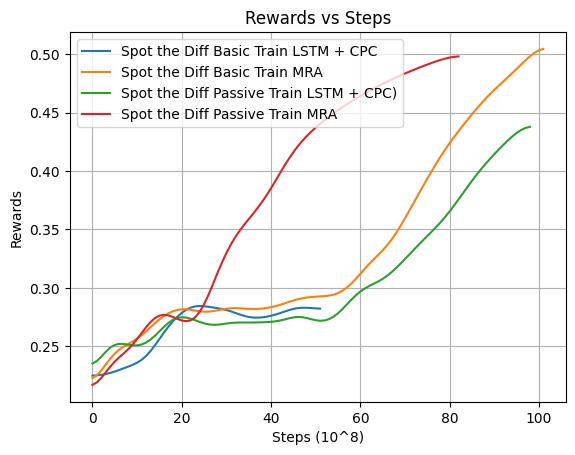

In [48]:
plot_rewards(gaussian_filter1d(reward, sigma = 3), gaussian_filter1d(reward1, sigma = 3), gaussian_filter1d(reward2, sigma = 3), gaussian_filter1d(reward3, sigma = 3))